### CoreBx process
Read the rotated, interpolated DSMs for the entire island and do volume calcs.

May 1, 2022

#### Input:
- .nc files creaded by `CoreBx_island`
- `offset.yml` file created by analyzing the stable points
- `cmap_ncb.pkl` - colormap created by
- `small_island_box.yml` - coordinated used to rotate to island coordsd


Working on  IGSAGIEGLTCHS10


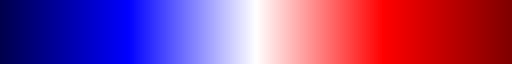

In [10]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime
import xarray as xr
import pandas as pd
import pickle
import netCDF4 as netcdf
from scipy import interpolate, signal
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve as astropy_convolve
from scipy.signal import convolve as scipy_convolve
from CoreBx_funcs import *
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

drv, computername = which_computer()
print('Working on ',computername)

# These commands choose fonts that are editable in svg format
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# colors
dblue = '#1f77b4'
red3 = ['#fee0d2','#fc9272','#de2d26']
# oranges from ColorBrewer https://colorbrewer2.org/#type=sequential&scheme=PuBu&n=5
cols=['#feedde','#fdbe85','#fd8d3c','#e6550d','#a63603']
blue5=['#f1eef6','#bdc9e1','#bdc9e1','#2b8cbe','#045a8d']
green5=['#edf8e9','#bae4b3','#74c476','#31a354','#006d2c']
purple5 = ['#f2f0f7','#cbc9e2','#9e9ac8','#756bb1','#54278f']

# This is the colormap made in SurferClr2Cmap.ipynb from NorthCore_ElevationShader_v2.clr
fp = open('cmap_ncb.pkl', 'rb')
cmap_ncb = pickle.load(fp)
fp.close()

# This makes NaN gray
tcmap=cmap_ncb
tcmap.set_bad(color='darkgray')

# This is the difference color map
dcmap = cm.seismic.copy()
dcmap.set_bad(color='darkgray')
dcmap

In [2]:
# load in map offsets
with open('offsets.yml') as f:
    offset = yaml.safe_load(f)
offset = np.array(offset)
print(offset)

[ 0.00168195  0.02229009 -0.02397204 -0.01150765 -0.07320715 -0.02726184
 -0.03547332 -0.02953579 -0.02719979  0.00756222]


In [4]:
# Dates for DEMs
dates = ([\
         "2019-08-30",\
         "2019-09-12",\
         "2019-10-11",\
         "2019-11-26"])

dem_path = drv+'crs/proj/2019_DorianOBX/Dorian_paper_analyses/rotated_dems/'

# # these offsets are the mean anomaly relative to the 10-map mean per Analyze_rotated_stable_points_refac
# offset = np.array([0.00168195,  0.02229009, -0.02397204, -0.01150765, -0.07320715, -0.02726184,
#  -0.03547332, -0.02953579, -0.02719979,  0.00756222])

MHHW = 0.4 #elevation of MHHW per VDATUM

# Read in a dict that defines the rotated "island" coordinate system
#  name
#  e0 - UTM Easting of origin [m]
#  n0 - UTM Northing of origin [m]
#  xlen - Length of alongshore axis [m]
#  ylen - Length of cross-shore axis [m]
#  dxdy - grid size (must be isotropic right now) [m]
#  theta - rotation CCW from x-axis [deg]
#  xs_end - number of grid cells to approximate limit of overwash terrace
#  d_end - number of grid cells to 
r = yaml2dict('small_island_box.yml')
print(r)

# initialize maps arrays fo
nmaps = len(dates)
vsum = np.zeros((nmaps))
vsumall = np.zeros((nmaps))
vchange = np.zeros((nmaps-1))
vchangeall = np.zeros((nmaps-1))

statsfn = "process_stats_{}.txt".format(r['name'])
sfile = open(statsfn, "w")

print("",file=sfile)
print('Region: ',r['name'],file=sfile)

{'name': 'ncorebx_small', 'e0': 383520.0, 'n0': 3860830.0, 'xlen': 25000.0, 'ylen': 1200.0, 'dxdy': 1.0, 'theta': 42.0}


### Read in the re-clipped maps to analyze for shoreline, dune crest, and island back

In [5]:
# read in the multi-map reclipped .nc file
fn = r['name']+'_reclip.nc'
dsa = xr.open_dataset(dem_path+fn)
dsaa = np.squeeze(dsa.to_array())
nmaps,ncross,nalong=np.shape(dsaa)
print('nmaps, ncross, nalong: ',nmaps,ncross,nalong)

xdist = dsaa['Alongshore'].to_numpy()
ydist = dsaa['Cross-shore'].to_numpy()

# Correct for uniform offsets
for i in range(0, nmaps):
    dsaa[i,:,:] = dsaa[i,:,:] - offset[i] 

nmaps, ncross, nalong:  4 1200 25000


In [7]:
# find first valid point
%run -i CoreBx_funcs
ydist = np.arange(0.,ncross)
print(dist)
ix = np.zeros((nalong, nmaps))
dinit = np.zeros((nalong, nmaps))
zinit = np.zeros((nalong, nmaps))
bp = np.zeros((nalong, nmaps))
for j in range(nmaps):
    print('Map',j)
    for i in range(nalong):
        prof = np.squeeze(np.array((dsaa[j,:,i])))
        ix[i,j], dinit[i,j], zinit[i,j], bp[i,j], = find_first_valid(ydist, prof)
print('Done.')

[0.000e+00 1.000e+00 2.000e+00 ... 1.197e+03 1.198e+03 1.199e+03]
Map 0
Map 1
Map 2
all nans in extend beach
all nans in extend beach
all nans in extend beach
all nans in extend beach
all nans in extend beach
all nans in extend beach
all nans in extend beach
all nans in extend beach
all nans in extend beach
all nans in extend beach
all nans in extend beach
all nans in extend beach
all nans in extend beach
all nans in extend beach
all nans in extend beach
all nans in extend beach
all nans in extend beach
all nans in extend beach
all nans in extend beach
all nans in extend beach
all nans in extend beach
all nans in extend beach
all nans in extend beach
all nans in extend beach
Map 3


In [17]:
# export shoreline locations to csv
csv_dir = drv+'crs/proj/2019_DorianOBX/Dorian_paper_analyses/'
Aug_shorex, Aug_shorey = island2UTM(xdist, ix[:,0], r['e0'], r['n0'], r['theta'])
pd.DataFrame((np.vstack((Aug_shorex, Aug_shorey)).T).round(decimals=2)).to_csv(csv_dir+'Aug_shoreline.csv',header=None, index=None)

Sep_shorex, Sep_shorey = island2UTM(xdist, ix[:,1], r['e0'], r['n0'], r['theta'])
pd.DataFrame((np.vstack((Sep_shorex, Sep_shorey)).T).round(decimals=2)).to_csv(csv_dir+'Sep_shoreline.csv',header=None, index=None)

Oct_shorex, Oct_shorey = island2UTM(xdist, ix[:,2], r['e0'], r['n0'], r['theta'])
pd.DataFrame((np.vstack((Oct_shorex, Oct_shorey)).T).round(decimals=2)).to_csv(csv_dir+'Oct_shoreline.csv',header=None, index=None)

Nov_shorex, Nov_shorey = island2UTM(xdist, ix[:,3], r['e0'], r['n0'], r['theta'])
pd.DataFrame((np.vstack((Nov_shorex, Nov_shorey)).T).round(decimals=2)).to_csv(csv_dir+'Nov_shoreline.csv',header=None, index=None)

C:/crs/proj/2019_DorianOBX/Dorian_paper_analyses/Aug_shoreline.csv


### Smooth the maps with a 5-point Gaussian kernal that will fill in NaNs
The boundary='fill' and fill_value=np.nan arguments prevent the default behavior of putting zeros where kernel touches boundaries.

In [18]:
%%time
ismooth = True
if ismooth:
    kernel = Gaussian2DKernel(x_stddev=.5)
    print('Size of kernel: ', kernel.shape)
    
    for i in range(0, nmaps):
        dsaa[i,:,:] = astropy_convolve(dsaa[i,:,:], kernel, boundary='fill', fill_value=np.nan)


Size of kernel:  (5, 5)
CPU times: total: 12.7 s
Wall time: 12.7 s


In [6]:
%run -i CoreBx_funcs
dist = np.arange(0.,ncross)
print(dist)

profile_list = range(0,nalong,1)
icross = np.zeros((nalong, nmaps))
ix = np.zeros((nalong, nmaps))

zinit = np.zeros((nalong, nmaps))
del_vol = np.zeros((nalong, nmaps))
bp = np.zeros((nalong, nmaps))

nprofs = len(profile_list)
print(nprofs, profile_list)

# array of maps with extended profiles
dsaxb = dsaa.copy()
nmap = 0

[0.000e+00 1.000e+00 2.000e+00 ... 1.197e+03 1.198e+03 1.199e+03]
25000 range(0, 25000)


In [ ]:
### Find peak and back side

In [7]:
for j in range(nmaps):
    print('Map',j)
    for i in range(nalong):
        prof = np.squeeze(np.array((dsaa[j,:,i])))
        ix[i,j], icross[i,j], zinit[i,j], del_vol[i,j], bp[i,j], dsaxb[j,:,i] = extend_beach(dist, prof, zm = 0.4, slope=0.09)

Map 0
Map 1
Map 2
too many NaNs in first npts 1 [334.] [1.1209521]
too many NaNs in first npts 1 [334.] [1.025919]
too many NaNs in first npts 1 [569.] [0.5354251]
too many NaNs in first npts 1 [473.] [0.69295204]
too many NaNs in first npts 1 [474.] [0.703952]
too many NaNs in first npts 1 [461.] [0.59995204]
too many NaNs in first npts 1 [424.] [0.6168828]
too many NaNs in first npts 1 [424.] [0.579952]
too many NaNs in first npts 1 [439.] [0.74774426]
too many NaNs in first npts 1 [540.] [0.42095202]
too many NaNs in first npts 1 [540.] [0.46895203]
too many NaNs in first npts 1 [501.] [0.45565048]
too many NaNs in first npts 1 [353.] [0.51379436]
too many NaNs in first npts 1 [721.] [0.57452047]
too many NaNs in first npts 1 [764.] [0.45787746]
all nans in extend beach
all nans in extend beach
all nans in extend beach
all nans in extend beach
all nans in extend beach
all nans in extend beach
all nans in extend beach
all nans in extend beach
all nans in extend beach
all nans in exte

too many NaNs in first npts 1 [36.] [1.8703183]
too many NaNs in first npts 1 [11.] [1.6950891]
too many NaNs in first npts 1 [11.] [2.103275]
too many NaNs in first npts 1 [10.] [1.8665553]
too many NaNs in first npts 1 [13.] [1.4665504]
too many NaNs in first npts 1 [5.] [1.9198288]
too many NaNs in first npts 1 [6.] [3.0834105]
too many NaNs in first npts 1 [5.] [3.347693]
too many NaNs in first npts 1 [5.] [3.0662844]
too many NaNs in first npts 1 [6.] [0.44459528]
too many NaNs in first npts 1 [24.] [0.66776437]
too many NaNs in first npts 1 [22.] [0.8671287]
too many NaNs in first npts 1 [22.] [0.5116978]
too many NaNs in first npts 1 [21.] [0.76171654]
too many NaNs in first npts 1 [19.] [0.84920007]
too many NaNs in first npts 1 [40.] [2.1709554]
too many NaNs in first npts 1 [31.] [2.6895626]
too many NaNs in first npts 1 [30.] [1.8314546]
too many NaNs in first npts 1 [31.] [2.1860332]
too many NaNs in first npts 1 [25.] [0.65060925]
too many NaNs in first npts 1 [35.] [0.924

too many NaNs in first npts 1 [147.] [0.6368554]
too many NaNs in first npts 1 [145.] [2.914286]
too many NaNs in first npts 1 [150.] [1.3980005]
too many NaNs in first npts 1 [149.] [1.6592585]
too many NaNs in first npts 1 [170.] [1.1055212]
too many NaNs in first npts 1 [167.] [2.3527343]
too many NaNs in first npts 1 [165.] [1.7026168]
too many NaNs in first npts 1 [176.] [2.3490436]
too many NaNs in first npts 1 [178.] [1.5785284]
too many NaNs in first npts 1 [171.] [0.88753176]
too many NaNs in first npts 1 [175.] [2.4396305]
too many NaNs in first npts 1 [174.] [0.6741172]
too many NaNs in first npts 1 [172.] [0.98289496]
too many NaNs in first npts 1 [170.] [1.8099707]
too many NaNs in first npts 1 [170.] [0.76948303]
too many NaNs in first npts 1 [171.] [2.101404]
too many NaNs in first npts 1 [173.] [3.768901]
too many NaNs in first npts 1 [172.] [4.1658235]
too many NaNs in first npts 1 [172.] [3.3717992]
too many NaNs in first npts 1 [173.] [0.93238366]
too many NaNs in fi

too many NaNs in first npts 1 [289.] [1.0264108]
too many NaNs in first npts 1 [289.] [1.4935644]
too many NaNs in first npts 1 [289.] [1.4618704]
too many NaNs in first npts 1 [289.] [1.8112836]
too many NaNs in first npts 1 [287.] [5.16688]
too many NaNs in first npts 1 [288.] [4.7373405]
too many NaNs in first npts 1 [289.] [4.1822553]
too many NaNs in first npts 1 [288.] [3.7799847]
too many NaNs in first npts 1 [296.] [2.065248]
too many NaNs in first npts 1 [294.] [3.265626]
too many NaNs in first npts 1 [306.] [0.8969351]
too many NaNs in first npts 1 [306.] [1.0956852]
too many NaNs in first npts 1 [306.] [1.4964348]
too many NaNs in first npts 1 [319.] [0.63559806]
too many NaNs in first npts 1 [315.] [6.1656437]
too many NaNs in first npts 1 [315.] [6.1656437]
too many NaNs in first npts 1 [314.] [2.6216729]
too many NaNs in first npts 1 [330.] [0.53338]
too many NaNs in first npts 1 [257.] [1.0196296]
too many NaNs in first npts 1 [263.] [0.9215366]
too many NaNs in first np

too many NaNs in first npts 1 [275.] [0.9497254]
too many NaNs in first npts 1 [292.] [5.0168066]
too many NaNs in first npts 1 [285.] [4.481851]
too many NaNs in first npts 1 [293.] [0.60720736]
too many NaNs in first npts 1 [293.] [0.4616342]
too many NaNs in first npts 1 [288.] [10.411973]
too many NaNs in first npts 1 [312.] [0.5283384]
too many NaNs in first npts 1 [310.] [2.35161]
too many NaNs in first npts 1 [313.] [2.7252002]
too many NaNs in first npts 1 [313.] [2.5795]
too many NaNs in first npts 1 [289.] [1.8575957]
too many NaNs in first npts 1 [290.] [1.9417504]
too many NaNs in first npts 1 [289.] [1.9633884]
too many NaNs in first npts 1 [288.] [0.9941039]
too many NaNs in first npts 1 [288.] [1.0217986]
too many NaNs in first npts 1 [288.] [1.0217986]
too many NaNs in first npts 1 [287.] [1.3438027]
too many NaNs in first npts 1 [288.] [2.285062]
too many NaNs in first npts 1 [286.] [1.5313703]
too many NaNs in first npts 1 [286.] [1.321378]
too many NaNs in first npts

too many NaNs in first npts 1 [345.] [3.4480598]
too many NaNs in first npts 1 [345.] [4.360979]
too many NaNs in first npts 1 [337.] [3.6785116]
too many NaNs in first npts 1 [336.] [3.7160637]
too many NaNs in first npts 1 [330.] [1.5520868]
too many NaNs in first npts 1 [330.] [1.5520868]
too many NaNs in first npts 1 [312.] [1.849746]
too many NaNs in first npts 1 [312.] [2.090851]
too many NaNs in first npts 1 [311.] [4.2790847]
too many NaNs in first npts 1 [311.] [4.013124]
too many NaNs in first npts 1 [311.] [3.301809]
too many NaNs in first npts 1 [312.] [2.45382]
too many NaNs in first npts 1 [312.] [1.1635778]
too many NaNs in first npts 1 [262.] [2.1449647]
too many NaNs in first npts 1 [262.] [2.150571]
too many NaNs in first npts 1 [262.] [2.150571]
too many NaNs in first npts 1 [261.] [2.2342286]
too many NaNs in first npts 1 [262.] [0.85221225]
too many NaNs in first npts 1 [261.] [1.6325109]
too many NaNs in first npts 1 [262.] [1.7349825]
too many NaNs in first npts 

too many NaNs in first npts 1 [218.] [1.1530926]
too many NaNs in first npts 1 [218.] [1.6738874]
too many NaNs in first npts 1 [219.] [2.0741036]
too many NaNs in first npts 1 [218.] [1.6925253]
too many NaNs in first npts 1 [220.] [2.1160278]
too many NaNs in first npts 1 [222.] [1.1242118]
too many NaNs in first npts 1 [221.] [1.4775617]
too many NaNs in first npts 1 [232.] [0.9066372]
too many NaNs in first npts 1 [227.] [0.88893723]
too many NaNs in first npts 1 [228.] [2.277864]
too many NaNs in first npts 1 [232.] [0.74426264]
too many NaNs in first npts 1 [148.] [2.482163]
Map 5
too many NaNs in first npts 1 [93.] [1.0486933]
too many NaNs in first npts 1 [95.] [2.4050617]
too many NaNs in first npts 1 [96.] [5.5660977]
too many NaNs in first npts 1 [97.] [5.01866]
too many NaNs in first npts 1 [99.] [5.589616]
too many NaNs in first npts 1 [102.] [5.594123]
too many NaNs in first npts 1 [99.] [7.7640424]
too many NaNs in first npts 1 [100.] [7.2540727]
too many NaNs in first n

too many NaNs in first npts 1 [24.] [4.7029433]
too many NaNs in first npts 1 [23.] [2.4346967]
too many NaNs in first npts 1 [21.] [3.3295636]
too many NaNs in first npts 1 [38.] [4.4610896]
too many NaNs in first npts 1 [29.] [1.6773127]
too many NaNs in first npts 1 [16.] [4.0738697]
too many NaNs in first npts 1 [16.] [7.8005543]
too many NaNs in first npts 1 [19.] [7.924913]
too many NaNs in first npts 1 [14.] [6.328119]
too many NaNs in first npts 1 [14.] [5.940196]
too many NaNs in first npts 1 [22.] [6.6365933]
too many NaNs in first npts 1 [17.] [6.2208037]
too many NaNs in first npts 1 [23.] [6.024231]
too many NaNs in first npts 1 [24.] [4.387572]
too many NaNs in first npts 1 [24.] [4.387572]
too many NaNs in first npts 1 [26.] [5.2716665]
too many NaNs in first npts 1 [21.] [5.686186]
too many NaNs in first npts 1 [15.] [7.31788]
too many NaNs in first npts 1 [13.] [10.164584]
too many NaNs in first npts 1 [20.] [5.714265]
too many NaNs in first npts 1 [17.] [7.538152]
too

too many NaNs in first npts 1 [1.] [1.812373]
too many NaNs in first npts 1 [2.] [0.6654192]
too many NaNs in first npts 1 [6.] [1.226734]
too many NaNs in first npts 1 [0.] [1.3812541]
too many NaNs in first npts 1 [0.] [1.5999625]
too many NaNs in first npts 1 [0.] [2.4686677]
too many NaNs in first npts 1 [0.] [1.5305582]
too many NaNs in first npts 1 [0.] [1.5305582]
too many NaNs in first npts 1 [0.] [1.1840774]
too many NaNs in first npts 1 [0.] [0.8208296]
too many NaNs in first npts 1 [9.] [0.44618943]
too many NaNs in first npts 1 [4.] [1.6181738]
too many NaNs in first npts 1 [4.] [1.0387803]
too many NaNs in first npts 1 [9.] [2.2899735]
too many NaNs in first npts 1 [1.] [2.7931194]
too many NaNs in first npts 1 [1.] [3.6809297]
too many NaNs in first npts 1 [13.] [2.3569071]
too many NaNs in first npts 1 [0.] [3.9625578]
too many NaNs in first npts 1 [0.] [4.6198635]
too many NaNs in first npts 1 [1.] [4.393656]
too many NaNs in first npts 1 [2.] [3.562333]
too many NaNs i

too many NaNs in first npts 1 [122.] [5.925085]
too many NaNs in first npts 1 [121.] [6.5382733]
too many NaNs in first npts 1 [126.] [5.6865597]
too many NaNs in first npts 1 [123.] [3.2795565]
too many NaNs in first npts 1 [123.] [0.45956346]
too many NaNs in first npts 1 [127.] [0.8066235]
too many NaNs in first npts 1 [126.] [1.2005266]
too many NaNs in first npts 1 [145.] [1.0132018]
too many NaNs in first npts 1 [84.] [0.9867225]
too many NaNs in first npts 1 [75.] [1.0235484]
too many NaNs in first npts 1 [72.] [0.4438598]
too many NaNs in first npts 1 [78.] [1.1448334]
too many NaNs in first npts 1 [79.] [1.3354422]
too many NaNs in first npts 1 [74.] [0.52756494]
too many NaNs in first npts 1 [70.] [1.4227985]
too many NaNs in first npts 1 [72.] [1.4191453]
too many NaNs in first npts 1 [77.] [1.011504]
too many NaNs in first npts 1 [73.] [0.5468038]
too many NaNs in first npts 1 [90.] [1.1827517]
too many NaNs in first npts 1 [87.] [0.8988376]
too many NaNs in first npts 1 [7

too many NaNs in first npts 1 [299.] [6.47858]
too many NaNs in first npts 1 [298.] [4.333089]
too many NaNs in first npts 1 [300.] [5.982426]
too many NaNs in first npts 1 [299.] [1.1773468]
too many NaNs in first npts 1 [301.] [0.7752701]
too many NaNs in first npts 1 [300.] [0.6880389]
too many NaNs in first npts 1 [309.] [2.9716396]
too many NaNs in first npts 1 [308.] [3.9445224]
too many NaNs in first npts 1 [311.] [4.171167]
too many NaNs in first npts 1 [310.] [4.6009526]
too many NaNs in first npts 1 [307.] [1.3388009]
too many NaNs in first npts 1 [308.] [0.48526227]
too many NaNs in first npts 1 [306.] [0.54474384]
too many NaNs in first npts 1 [308.] [2.5395555]
too many NaNs in first npts 1 [309.] [1.7737776]
too many NaNs in first npts 1 [309.] [0.77194095]
too many NaNs in first npts 1 [311.] [2.3932734]
too many NaNs in first npts 1 [309.] [1.4177524]
too many NaNs in first npts 1 [313.] [2.9342253]
too many NaNs in first npts 1 [314.] [3.0666704]
too many NaNs in first

too many NaNs in first npts 1 [310.] [6.10189]
too many NaNs in first npts 1 [302.] [2.638655]
too many NaNs in first npts 1 [303.] [1.4101615]
too many NaNs in first npts 1 [301.] [1.0297596]
too many NaNs in first npts 1 [302.] [0.9422893]
too many NaNs in first npts 1 [303.] [1.9280174]
too many NaNs in first npts 1 [305.] [0.9806697]
too many NaNs in first npts 1 [308.] [4.822743]
too many NaNs in first npts 1 [313.] [2.1345403]
too many NaNs in first npts 1 [308.] [3.415176]
too many NaNs in first npts 1 [307.] [2.9895465]
too many NaNs in first npts 1 [285.] [1.3655784]
too many NaNs in first npts 1 [284.] [1.3041012]
too many NaNs in first npts 1 [344.] [2.6630387]
too many NaNs in first npts 1 [334.] [3.555644]
too many NaNs in first npts 1 [335.] [1.9344541]
too many NaNs in first npts 1 [336.] [1.1428313]
too many NaNs in first npts 1 [329.] [1.3129942]
too many NaNs in first npts 1 [328.] [0.41788626]
too many NaNs in first npts 1 [328.] [0.83907264]
too many NaNs in first n

too many NaNs in first npts 1 [334.] [5.9351187]
too many NaNs in first npts 1 [332.] [4.7643356]
too many NaNs in first npts 1 [345.] [3.453547]
too many NaNs in first npts 1 [344.] [0.666444]
too many NaNs in first npts 1 [348.] [2.285818]
too many NaNs in first npts 1 [339.] [3.805045]
too many NaNs in first npts 1 [322.] [4.2064295]
too many NaNs in first npts 1 [316.] [6.578894]
too many NaNs in first npts 1 [316.] [4.5102453]
too many NaNs in first npts 1 [320.] [4.556634]
too many NaNs in first npts 1 [317.] [4.9293175]
too many NaNs in first npts 1 [317.] [4.9293175]
too many NaNs in first npts 1 [315.] [5.592433]
too many NaNs in first npts 1 [320.] [4.5810604]
too many NaNs in first npts 1 [317.] [4.9206095]
too many NaNs in first npts 1 [322.] [4.243284]
too many NaNs in first npts 1 [326.] [7.698646]
too many NaNs in first npts 1 [321.] [4.430581]
too many NaNs in first npts 1 [339.] [6.64726]
too many NaNs in first npts 1 [325.] [2.9083576]
too many NaNs in first npts 1 [3

too many NaNs in first npts 1 [266.] [4.00923]
too many NaNs in first npts 1 [263.] [4.440551]
too many NaNs in first npts 1 [268.] [5.534112]
too many NaNs in first npts 1 [266.] [1.9762535]
too many NaNs in first npts 1 [266.] [1.4224379]
too many NaNs in first npts 1 [265.] [1.0010235]
too many NaNs in first npts 1 [266.] [0.69784045]
too many NaNs in first npts 1 [264.] [0.8194139]
too many NaNs in first npts 1 [264.] [1.2438122]
too many NaNs in first npts 1 [265.] [0.41916057]
too many NaNs in first npts 1 [265.] [0.6639567]
too many NaNs in first npts 1 [260.] [2.7605915]
too many NaNs in first npts 1 [259.] [2.9871645]
too many NaNs in first npts 1 [262.] [0.95408314]
too many NaNs in first npts 1 [263.] [1.0000516]
too many NaNs in first npts 1 [261.] [0.5486384]
too many NaNs in first npts 1 [256.] [0.7705856]
too many NaNs in first npts 1 [268.] [4.062483]
too many NaNs in first npts 1 [256.] [1.2248276]
too many NaNs in first npts 1 [259.] [1.142668]
too many NaNs in first 

too many NaNs in first npts 1 [98.] [5.2230387]
too many NaNs in first npts 1 [97.] [5.997262]
too many NaNs in first npts 1 [96.] [5.9135814]
too many NaNs in first npts 1 [95.] [6.1354628]
too many NaNs in first npts 1 [96.] [6.3212824]
too many NaNs in first npts 1 [93.] [6.3536363]
too many NaNs in first npts 1 [92.] [6.571035]
too many NaNs in first npts 1 [92.] [6.7478685]
too many NaNs in first npts 1 [92.] [7.082835]
too many NaNs in first npts 1 [82.] [1.6794219]
too many NaNs in first npts 1 [81.] [1.5843651]
too many NaNs in first npts 1 [86.] [15.981777]
too many NaNs in first npts 1 [78.] [4.2899747]
too many NaNs in first npts 1 [75.] [3.3687475]
Map 6
too many NaNs in first npts 1 [116.] [0.40465754]
too many NaNs in first npts 1 [114.] [0.8055509]
too many NaNs in first npts 1 [116.] [1.6752898]
too many NaNs in first npts 1 [113.] [0.9146282]
too many NaNs in first npts 1 [115.] [1.0734712]
too many NaNs in first npts 1 [125.] [0.45782024]
too many NaNs in first npts 1

too many NaNs in first npts 1 [44.] [0.7310198]
too many NaNs in first npts 1 [44.] [0.4057285]
too many NaNs in first npts 1 [37.] [6.3072033]
too many NaNs in first npts 1 [20.] [3.29684]
too many NaNs in first npts 1 [36.] [0.49648273]
too many NaNs in first npts 1 [30.] [1.1433612]
too many NaNs in first npts 1 [31.] [1.93572]
too many NaNs in first npts 1 [31.] [1.44052]
too many NaNs in first npts 1 [11.] [1.3153731]
too many NaNs in first npts 1 [14.] [1.0869097]
too many NaNs in first npts 1 [27.] [0.5859619]
too many NaNs in first npts 1 [16.] [2.3744502]
too many NaNs in first npts 1 [23.] [1.8583319]
too many NaNs in first npts 1 [22.] [1.033773]
too many NaNs in first npts 1 [21.] [1.300426]
too many NaNs in first npts 1 [18.] [1.1106077]
too many NaNs in first npts 1 [27.] [0.46239632]
too many NaNs in first npts 1 [32.] [0.86729944]
too many NaNs in first npts 1 [33.] [0.63570476]
too many NaNs in first npts 1 [36.] [2.155542]
too many NaNs in first npts 1 [36.] [2.007803

too many NaNs in first npts 1 [271.] [2.5992124]
too many NaNs in first npts 1 [272.] [1.556347]
too many NaNs in first npts 1 [272.] [1.4724973]
too many NaNs in first npts 1 [272.] [1.4724973]
too many NaNs in first npts 1 [272.] [0.8857716]
too many NaNs in first npts 1 [276.] [1.0773565]
too many NaNs in first npts 1 [282.] [2.2095153]
too many NaNs in first npts 1 [282.] [1.2770188]
too many NaNs in first npts 1 [277.] [1.3133154]
too many NaNs in first npts 1 [275.] [1.1374937]
too many NaNs in first npts 1 [275.] [5.663328]
too many NaNs in first npts 1 [267.] [0.45612013]
too many NaNs in first npts 1 [260.] [5.4261036]
too many NaNs in first npts 1 [262.] [4.45893]
too many NaNs in first npts 1 [261.] [3.626728]
too many NaNs in first npts 1 [262.] [4.601223]
too many NaNs in first npts 1 [265.] [2.2277298]
too many NaNs in first npts 1 [262.] [2.2046175]
too many NaNs in first npts 1 [262.] [4.528294]
too many NaNs in first npts 1 [262.] [5.182906]
too many NaNs in first npts

too many NaNs in first npts 1 [342.] [1.314657]
too many NaNs in first npts 1 [342.] [1.5387777]
too many NaNs in first npts 1 [348.] [1.8172997]
too many NaNs in first npts 1 [347.] [4.2034874]
too many NaNs in first npts 1 [355.] [1.5878713]
too many NaNs in first npts 1 [346.] [3.8006613]
too many NaNs in first npts 1 [347.] [1.7238313]
too many NaNs in first npts 1 [352.] [3.104968]
too many NaNs in first npts 1 [353.] [0.97928995]
too many NaNs in first npts 1 [352.] [0.5235581]
too many NaNs in first npts 1 [352.] [0.7317873]
too many NaNs in first npts 1 [351.] [0.60506344]
too many NaNs in first npts 1 [337.] [4.950151]
too many NaNs in first npts 1 [335.] [3.7693946]
too many NaNs in first npts 1 [334.] [4.2883444]
too many NaNs in first npts 1 [336.] [3.494443]
too many NaNs in first npts 1 [334.] [2.5682187]
too many NaNs in first npts 1 [332.] [2.4974148]
too many NaNs in first npts 1 [334.] [2.7775466]
too many NaNs in first npts 1 [329.] [6.4092975]
too many NaNs in first

too many NaNs in first npts 1 [324.] [1.1090839]
too many NaNs in first npts 1 [308.] [0.6865891]
too many NaNs in first npts 1 [309.] [0.5809625]
too many NaNs in first npts 1 [331.] [4.6218257]
too many NaNs in first npts 1 [330.] [4.80283]
too many NaNs in first npts 1 [329.] [5.357038]
too many NaNs in first npts 1 [318.] [0.9810799]
too many NaNs in first npts 1 [334.] [1.286714]
too many NaNs in first npts 1 [336.] [0.45731825]
too many NaNs in first npts 1 [312.] [1.876701]
too many NaNs in first npts 1 [331.] [0.5191719]
too many NaNs in first npts 1 [331.] [1.0383561]
too many NaNs in first npts 1 [323.] [0.8630687]
too many NaNs in first npts 1 [323.] [0.9919382]
too many NaNs in first npts 1 [324.] [0.75321704]
too many NaNs in first npts 1 [331.] [0.8705453]
too many NaNs in first npts 1 [332.] [0.9704078]
too many NaNs in first npts 1 [332.] [1.4423876]
too many NaNs in first npts 1 [331.] [2.0564053]
too many NaNs in first npts 1 [331.] [2.629859]
too many NaNs in first n

too many NaNs in first npts 1 [348.] [1.0476642]
too many NaNs in first npts 1 [344.] [0.7295132]
too many NaNs in first npts 1 [345.] [0.8925797]
too many NaNs in first npts 1 [342.] [1.0875667]
too many NaNs in first npts 1 [342.] [0.6573472]
too many NaNs in first npts 1 [342.] [0.7026134]
too many NaNs in first npts 1 [341.] [0.72093296]
too many NaNs in first npts 1 [354.] [0.9424159]
too many NaNs in first npts 1 [350.] [0.6316869]
too many NaNs in first npts 1 [346.] [0.47031265]
too many NaNs in first npts 1 [349.] [0.61593264]
too many NaNs in first npts 1 [351.] [1.3743987]
too many NaNs in first npts 1 [349.] [0.91152006]
too many NaNs in first npts 1 [348.] [0.7914937]
too many NaNs in first npts 1 [341.] [1.4999629]
too many NaNs in first npts 1 [341.] [1.3182875]
too many NaNs in first npts 1 [339.] [1.572828]
too many NaNs in first npts 1 [339.] [1.0743196]
too many NaNs in first npts 1 [338.] [0.4638663]
too many NaNs in first npts 1 [343.] [0.80666226]
too many NaNs in

too many NaNs in first npts 1 [89.] [0.8377349]
too many NaNs in first npts 1 [110.] [5.598191]
too many NaNs in first npts 1 [110.] [4.5419145]
too many NaNs in first npts 1 [93.] [1.0053579]
too many NaNs in first npts 1 [109.] [6.4516177]
too many NaNs in first npts 1 [93.] [3.65278]
too many NaNs in first npts 1 [92.] [2.6603806]
too many NaNs in first npts 1 [93.] [4.3052597]
too many NaNs in first npts 1 [93.] [4.2220716]
too many NaNs in first npts 1 [104.] [9.411343]
too many NaNs in first npts 1 [105.] [9.244822]
too many NaNs in first npts 1 [93.] [4.944605]
too many NaNs in first npts 1 [89.] [1.6480376]
too many NaNs in first npts 1 [91.] [4.45787]
too many NaNs in first npts 1 [103.] [4.97647]
too many NaNs in first npts 1 [99.] [4.598976]
too many NaNs in first npts 1 [95.] [2.6934288]
too many NaNs in first npts 1 [97.] [6.2654457]
too many NaNs in first npts 1 [98.] [7.363964]
too many NaNs in first npts 1 [102.] [5.926242]
too many NaNs in first npts 1 [97.] [2.501604]

too many NaNs in first npts 1 [4.] [2.0497074]
too many NaNs in first npts 1 [7.] [2.9814982]
too many NaNs in first npts 1 [41.] [0.7031628]
too many NaNs in first npts 1 [15.] [1.3825707]
too many NaNs in first npts 1 [39.] [0.45759577]
too many NaNs in first npts 1 [8.] [1.236934]
too many NaNs in first npts 1 [0.] [0.5283824]
too many NaNs in first npts 1 [17.] [1.7947093]
too many NaNs in first npts 1 [11.] [1.061401]
too many NaNs in first npts 1 [0.] [1.5360821]
too many NaNs in first npts 1 [24.] [1.4427955]
too many NaNs in first npts 1 [25.] [0.63530654]
too many NaNs in first npts 1 [11.] [0.9503115]
too many NaNs in first npts 1 [4.] [1.9065955]
too many NaNs in first npts 1 [2.] [1.6120585]
too many NaNs in first npts 1 [12.] [3.4228187]
too many NaNs in first npts 1 [8.] [2.0225224]
too many NaNs in first npts 1 [9.] [3.7707405]
too many NaNs in first npts 1 [0.] [6.1103525]
too many NaNs in first npts 1 [2.] [3.2150877]
too many NaNs in first npts 1 [17.] [0.86727715]
to

too many NaNs in first npts 1 [6.] [1.1956382]
too many NaNs in first npts 1 [3.] [4.091001]
too many NaNs in first npts 1 [11.] [0.421558]
too many NaNs in first npts 1 [12.] [5.503555]
too many NaNs in first npts 1 [7.] [5.087011]
too many NaNs in first npts 1 [4.] [4.463668]
too many NaNs in first npts 1 [11.] [3.538619]
too many NaNs in first npts 1 [2.] [3.4115722]
too many NaNs in first npts 1 [9.] [0.7830702]
too many NaNs in first npts 1 [8.] [1.2805562]
too many NaNs in first npts 1 [2.] [0.8891076]
too many NaNs in first npts 1 [2.] [1.385608]
too many NaNs in first npts 1 [2.] [1.8047527]
too many NaNs in first npts 1 [1.] [3.3243563]
too many NaNs in first npts 1 [4.] [1.7472448]
too many NaNs in first npts 1 [4.] [1.2803016]
too many NaNs in first npts 1 [9.] [0.5152922]
too many NaNs in first npts 1 [8.] [2.4548922]
too many NaNs in first npts 1 [6.] [1.0958533]
too many NaNs in first npts 1 [11.] [1.8275664]
too many NaNs in first npts 1 [11.] [0.6118838]
too many NaNs i

too many NaNs in first npts 1 [23.] [1.9602871]
too many NaNs in first npts 1 [2.] [0.6053838]
too many NaNs in first npts 1 [10.] [2.8624318]
too many NaNs in first npts 1 [12.] [1.0637708]
too many NaNs in first npts 1 [4.] [0.66660774]
too many NaNs in first npts 1 [5.] [0.4997046]
too many NaNs in first npts 1 [5.] [1.561854]
too many NaNs in first npts 1 [0.] [0.41915557]
too many NaNs in first npts 1 [16.] [4.4255247]
too many NaNs in first npts 1 [18.] [4.5133657]
too many NaNs in first npts 1 [6.] [4.140782]
too many NaNs in first npts 1 [7.] [4.1250668]
too many NaNs in first npts 1 [15.] [4.5868964]
too many NaNs in first npts 1 [14.] [4.910976]
too many NaNs in first npts 1 [12.] [3.8645837]
too many NaNs in first npts 1 [7.] [3.0372863]
too many NaNs in first npts 1 [5.] [0.73844904]
too many NaNs in first npts 1 [4.] [0.7979674]
too many NaNs in first npts 1 [1.] [1.0580635]
too many NaNs in first npts 1 [0.] [1.1234198]
too many NaNs in first npts 1 [1.] [1.4501878]
too m

too many NaNs in first npts 1 [87.] [1.3233575]
too many NaNs in first npts 1 [71.] [0.8086866]
too many NaNs in first npts 1 [70.] [2.1750834]
too many NaNs in first npts 1 [70.] [1.2898798]
too many NaNs in first npts 1 [69.] [0.6990387]
too many NaNs in first npts 1 [69.] [0.8055017]
too many NaNs in first npts 1 [75.] [3.2195392]
too many NaNs in first npts 1 [95.] [4.2671337]
too many NaNs in first npts 1 [87.] [5.347571]
too many NaNs in first npts 1 [102.] [5.301788]
too many NaNs in first npts 1 [106.] [7.0748262]
too many NaNs in first npts 1 [90.] [4.850522]
too many NaNs in first npts 1 [91.] [7.243403]
too many NaNs in first npts 1 [120.] [0.6489147]
too many NaNs in first npts 1 [109.] [8.732825]
too many NaNs in first npts 1 [99.] [7.708304]
too many NaNs in first npts 1 [99.] [7.708304]
too many NaNs in first npts 1 [124.] [3.681603]
too many NaNs in first npts 1 [125.] [3.8015907]
too many NaNs in first npts 1 [73.] [1.2398957]
too many NaNs in first npts 1 [124.] [3.23

too many NaNs in first npts 1 [199.] [1.2450557]
too many NaNs in first npts 1 [213.] [0.43798035]
too many NaNs in first npts 1 [201.] [1.392219]
too many NaNs in first npts 1 [197.] [1.1127746]
too many NaNs in first npts 1 [194.] [0.40148774]
too many NaNs in first npts 1 [196.] [1.890179]
too many NaNs in first npts 1 [226.] [0.41829813]
too many NaNs in first npts 1 [225.] [1.0182341]
too many NaNs in first npts 1 [225.] [0.7766852]
too many NaNs in first npts 1 [225.] [1.2335417]
too many NaNs in first npts 1 [196.] [3.766069]
too many NaNs in first npts 1 [218.] [4.099127]
too many NaNs in first npts 1 [195.] [2.8635645]
too many NaNs in first npts 1 [195.] [2.8635645]
too many NaNs in first npts 1 [200.] [4.8365808]
too many NaNs in first npts 1 [193.] [4.4210634]
too many NaNs in first npts 1 [204.] [5.2637815]
too many NaNs in first npts 1 [194.] [2.445129]
too many NaNs in first npts 1 [201.] [3.843077]
too many NaNs in first npts 1 [211.] [3.747713]
too many NaNs in first n

too many NaNs in first npts 1 [299.] [3.3208055]
too many NaNs in first npts 1 [295.] [3.4719253]
too many NaNs in first npts 1 [301.] [3.3596053]
too many NaNs in first npts 1 [293.] [3.7904167]
too many NaNs in first npts 1 [296.] [0.8126745]
too many NaNs in first npts 1 [294.] [1.5090524]
too many NaNs in first npts 1 [279.] [1.2056739]
too many NaNs in first npts 1 [284.] [1.5713842]
too many NaNs in first npts 1 [297.] [1.518106]
too many NaNs in first npts 1 [279.] [0.7095492]
too many NaNs in first npts 1 [276.] [2.1715631]
too many NaNs in first npts 1 [293.] [2.0014517]
too many NaNs in first npts 1 [281.] [4.0684924]
too many NaNs in first npts 1 [277.] [2.089432]
too many NaNs in first npts 1 [273.] [2.3377676]
too many NaNs in first npts 1 [282.] [3.7053025]
too many NaNs in first npts 1 [274.] [4.4377866]
too many NaNs in first npts 1 [281.] [5.5789423]
too many NaNs in first npts 1 [278.] [4.071047]
too many NaNs in first npts 1 [288.] [1.5465027]
too many NaNs in first 

too many NaNs in first npts 1 [287.] [0.5567122]
too many NaNs in first npts 1 [290.] [0.94490904]
too many NaNs in first npts 1 [277.] [0.78908885]
too many NaNs in first npts 1 [271.] [2.065122]
too many NaNs in first npts 1 [268.] [1.3523413]
too many NaNs in first npts 1 [267.] [1.9568012]
too many NaNs in first npts 1 [266.] [1.0939215]
too many NaNs in first npts 1 [267.] [0.7492762]
too many NaNs in first npts 1 [266.] [0.54800713]
too many NaNs in first npts 1 [273.] [1.8486996]
too many NaNs in first npts 1 [273.] [1.8486996]
too many NaNs in first npts 1 [278.] [1.2151316]
too many NaNs in first npts 1 [271.] [2.1743057]
too many NaNs in first npts 1 [280.] [4.168432]
too many NaNs in first npts 1 [270.] [1.8219994]
too many NaNs in first npts 1 [330.] [0.97229344]
too many NaNs in first npts 1 [275.] [0.5284216]
too many NaNs in first npts 1 [274.] [0.74954027]
too many NaNs in first npts 1 [280.] [3.3784935]
too many NaNs in first npts 1 [271.] [1.2612891]
too many NaNs in 

too many NaNs in first npts 1 [287.] [1.7654777]
too many NaNs in first npts 1 [294.] [0.7581778]
too many NaNs in first npts 1 [277.] [1.3658332]
too many NaNs in first npts 1 [283.] [1.473017]
too many NaNs in first npts 1 [294.] [1.0506009]
too many NaNs in first npts 1 [289.] [1.0283891]
too many NaNs in first npts 1 [287.] [0.95646554]
too many NaNs in first npts 1 [292.] [1.2705413]
too many NaNs in first npts 1 [266.] [0.53306085]
too many NaNs in first npts 1 [284.] [0.8595769]
too many NaNs in first npts 1 [304.] [1.5253136]
too many NaNs in first npts 1 [267.] [1.1925638]
too many NaNs in first npts 1 [274.] [0.4774804]
too many NaNs in first npts 1 [275.] [0.7471324]
too many NaNs in first npts 1 [273.] [0.92375463]
too many NaNs in first npts 1 [272.] [0.78716844]
too many NaNs in first npts 1 [270.] [0.564638]
too many NaNs in first npts 1 [270.] [0.564638]
too many NaNs in first npts 1 [272.] [0.47276103]
too many NaNs in first npts 1 [272.] [1.3761303]
too many NaNs in f

too many NaNs in first npts 1 [318.] [1.9246835]
too many NaNs in first npts 1 [300.] [2.0062017]
too many NaNs in first npts 1 [305.] [1.3467791]
too many NaNs in first npts 1 [297.] [1.7242134]
too many NaNs in first npts 1 [299.] [3.5261185]
too many NaNs in first npts 1 [276.] [12.509662]
too many NaNs in first npts 1 [276.] [12.509662]
too many NaNs in first npts 1 [319.] [0.62491566]
too many NaNs in first npts 1 [275.] [13.887048]
too many NaNs in first npts 1 [274.] [14.078856]
too many NaNs in first npts 1 [279.] [4.810669]
too many NaNs in first npts 1 [294.] [4.0033092]
too many NaNs in first npts 1 [315.] [1.030563]
too many NaNs in first npts 1 [307.] [0.9605755]
too many NaNs in first npts 1 [308.] [2.4069283]
too many NaNs in first npts 1 [308.] [2.1185634]
too many NaNs in first npts 1 [307.] [1.4830862]
too many NaNs in first npts 1 [306.] [1.378722]
too many NaNs in first npts 1 [307.] [1.856029]
too many NaNs in first npts 1 [305.] [2.0203626]
too many NaNs in first 

too many NaNs in first npts 1 [311.] [0.46780157]
too many NaNs in first npts 1 [314.] [1.3235246]
too many NaNs in first npts 1 [321.] [0.42364767]
too many NaNs in first npts 1 [319.] [0.8211108]
too many NaNs in first npts 1 [325.] [1.1845855]
too many NaNs in first npts 1 [318.] [5.40537]
too many NaNs in first npts 1 [310.] [2.406122]
too many NaNs in first npts 1 [313.] [5.4075317]
too many NaNs in first npts 1 [318.] [3.8563693]
too many NaNs in first npts 1 [313.] [3.1975346]
too many NaNs in first npts 1 [315.] [1.8249578]
too many NaNs in first npts 1 [346.] [5.1658]
too many NaNs in first npts 1 [344.] [4.7737923]
too many NaNs in first npts 1 [349.] [9.495557]
too many NaNs in first npts 1 [362.] [1.4161335]
too many NaNs in first npts 1 [363.] [1.4413139]
too many NaNs in first npts 1 [366.] [1.2992135]
too many NaNs in first npts 1 [363.] [1.0026563]
too many NaNs in first npts 1 [363.] [1.0026563]
too many NaNs in first npts 1 [317.] [1.6202527]
too many NaNs in first np

too many NaNs in first npts 1 [299.] [1.1329403]
too many NaNs in first npts 1 [300.] [0.9847781]
too many NaNs in first npts 1 [300.] [0.65132505]
too many NaNs in first npts 1 [298.] [0.4453379]
too many NaNs in first npts 1 [301.] [0.7940337]
too many NaNs in first npts 1 [298.] [1.139652]
too many NaNs in first npts 1 [299.] [1.0815771]
too many NaNs in first npts 1 [300.] [1.1424422]
too many NaNs in first npts 1 [300.] [0.8471175]
too many NaNs in first npts 1 [301.] [1.0286328]
too many NaNs in first npts 1 [297.] [0.7656108]
too many NaNs in first npts 1 [298.] [1.0995145]
too many NaNs in first npts 1 [297.] [0.42346695]
too many NaNs in first npts 1 [297.] [0.42346695]
too many NaNs in first npts 1 [297.] [0.52066964]
too many NaNs in first npts 1 [296.] [0.60199416]
too many NaNs in first npts 1 [296.] [0.4114032]
too many NaNs in first npts 1 [296.] [2.4573805]
too many NaNs in first npts 1 [296.] [1.176584]
too many NaNs in first npts 1 [298.] [2.1958635]
too many NaNs in 

too many NaNs in first npts 1 [295.] [0.5302766]
too many NaNs in first npts 1 [294.] [0.46456945]
too many NaNs in first npts 1 [345.] [1.0766729]
too many NaNs in first npts 1 [338.] [5.3687434]
too many NaNs in first npts 1 [302.] [0.6819785]
too many NaNs in first npts 1 [303.] [0.8020965]
too many NaNs in first npts 1 [304.] [0.63159335]
too many NaNs in first npts 1 [304.] [0.87283266]
too many NaNs in first npts 1 [313.] [2.9784627]
too many NaNs in first npts 1 [310.] [2.4670079]
too many NaNs in first npts 1 [300.] [0.43075722]
too many NaNs in first npts 1 [299.] [0.6403947]
too many NaNs in first npts 1 [302.] [0.7131666]
too many NaNs in first npts 1 [314.] [0.47455114]
too many NaNs in first npts 1 [304.] [1.2688929]
too many NaNs in first npts 1 [314.] [2.1419227]
too many NaNs in first npts 1 [313.] [2.3400414]
too many NaNs in first npts 1 [299.] [1.0110267]
too many NaNs in first npts 1 [300.] [0.5190092]
too many NaNs in first npts 1 [311.] [2.8181906]
too many NaNs i

too many NaNs in first npts 1 [305.] [1.3094046]
too many NaNs in first npts 1 [346.] [0.5847932]
too many NaNs in first npts 1 [334.] [0.49606997]
too many NaNs in first npts 1 [320.] [5.0191026]
too many NaNs in first npts 1 [290.] [1.619138]
too many NaNs in first npts 1 [288.] [1.1865925]
too many NaNs in first npts 1 [339.] [1.5959871]
too many NaNs in first npts 1 [340.] [1.1976482]
too many NaNs in first npts 1 [319.] [12.931973]
too many NaNs in first npts 1 [300.] [2.9898174]
too many NaNs in first npts 1 [327.] [0.5299218]
too many NaNs in first npts 1 [303.] [1.9426694]
too many NaNs in first npts 1 [298.] [0.7149862]
too many NaNs in first npts 1 [295.] [2.7071605]
too many NaNs in first npts 1 [296.] [3.3602762]
too many NaNs in first npts 1 [302.] [3.067667]
too many NaNs in first npts 1 [291.] [3.9520814]
too many NaNs in first npts 1 [292.] [3.2423022]
too many NaNs in first npts 1 [291.] [2.4348862]
too many NaNs in first npts 1 [287.] [0.6490085]
too many NaNs in firs

too many NaNs in first npts 1 [283.] [3.9118426]
too many NaNs in first npts 1 [242.] [12.285062]
too many NaNs in first npts 1 [239.] [13.491112]
too many NaNs in first npts 1 [240.] [0.4474225]
too many NaNs in first npts 1 [240.] [0.7000305]
too many NaNs in first npts 1 [238.] [1.0607423]
too many NaNs in first npts 1 [238.] [1.5574963]
too many NaNs in first npts 1 [247.] [0.7867606]
too many NaNs in first npts 1 [255.] [2.2669992]
too many NaNs in first npts 1 [253.] [1.1719661]
too many NaNs in first npts 1 [247.] [2.6397686]
too many NaNs in first npts 1 [241.] [2.8503346]
too many NaNs in first npts 1 [242.] [2.712342]
too many NaNs in first npts 1 [241.] [2.8394709]
too many NaNs in first npts 1 [236.] [2.4772282]
too many NaNs in first npts 1 [259.] [0.45987028]
too many NaNs in first npts 1 [234.] [4.406283]
too many NaNs in first npts 1 [263.] [0.68909425]
too many NaNs in first npts 1 [277.] [1.8082663]
too many NaNs in first npts 1 [272.] [0.7162529]
too many NaNs in fir

too many NaNs in first npts 1 [206.] [3.100531]
too many NaNs in first npts 1 [186.] [0.9248932]
too many NaNs in first npts 1 [193.] [0.5535893]
too many NaNs in first npts 1 [195.] [0.98007375]
too many NaNs in first npts 1 [201.] [2.0390556]
too many NaNs in first npts 1 [194.] [1.8577573]
too many NaNs in first npts 1 [194.] [1.8111572]
too many NaNs in first npts 1 [200.] [0.4368322]
too many NaNs in first npts 1 [205.] [5.1804876]
too many NaNs in first npts 1 [200.] [1.562292]
too many NaNs in first npts 1 [199.] [2.415591]
too many NaNs in first npts 1 [207.] [6.304232]
too many NaNs in first npts 1 [207.] [6.132639]
too many NaNs in first npts 1 [187.] [0.5527615]
too many NaNs in first npts 1 [193.] [0.5208689]
too many NaNs in first npts 1 [193.] [0.960046]
too many NaNs in first npts 1 [196.] [0.52693236]
too many NaNs in first npts 1 [196.] [2.3828802]
too many NaNs in first npts 1 [163.] [3.2642968]
too many NaNs in first npts 1 [169.] [17.091738]
too many NaNs in first n

too many NaNs in first npts 1 [74.] [0.97410417]
too many NaNs in first npts 1 [82.] [0.5827898]
too many NaNs in first npts 1 [76.] [0.816884]
too many NaNs in first npts 1 [73.] [0.999043]
too many NaNs in first npts 1 [51.] [1.6188923]
too many NaNs in first npts 1 [51.] [1.6810051]
too many NaNs in first npts 1 [50.] [1.3646766]
too many NaNs in first npts 1 [46.] [0.964913]
too many NaNs in first npts 1 [53.] [1.3446653]
too many NaNs in first npts 1 [58.] [0.67543066]
too many NaNs in first npts 1 [52.] [3.2502296]
too many NaNs in first npts 1 [50.] [5.0657873]
too many NaNs in first npts 1 [50.] [5.0657873]
too many NaNs in first npts 1 [66.] [2.9246037]
too many NaNs in first npts 1 [71.] [1.6317745]
too many NaNs in first npts 1 [49.] [12.193114]
too many NaNs in first npts 1 [50.] [12.0771265]
too many NaNs in first npts 1 [60.] [1.2169822]
too many NaNs in first npts 1 [59.] [1.4980373]
too many NaNs in first npts 1 [56.] [0.5285789]
too many NaNs in first npts 1 [52.] [0.8

too many NaNs in first npts 1 [12.] [0.88832295]
too many NaNs in first npts 1 [15.] [0.41485178]
too many NaNs in first npts 1 [14.] [1.9194851]
too many NaNs in first npts 1 [15.] [2.054394]
too many NaNs in first npts 1 [18.] [1.3062311]
too many NaNs in first npts 1 [21.] [2.0078747]
too many NaNs in first npts 1 [20.] [0.8711653]
too many NaNs in first npts 1 [20.] [0.8711653]
too many NaNs in first npts 1 [21.] [0.75494605]
too many NaNs in first npts 1 [19.] [1.1084898]
too many NaNs in first npts 1 [26.] [0.9955834]
too many NaNs in first npts 1 [47.] [2.0101788]
too many NaNs in first npts 1 [18.] [4.4938073]
too many NaNs in first npts 1 [30.] [8.441616]
too many NaNs in first npts 1 [36.] [3.7685864]
too many NaNs in first npts 1 [12.] [5.965463]
too many NaNs in first npts 1 [14.] [2.6117036]
too many NaNs in first npts 1 [15.] [2.7005503]
too many NaNs in first npts 1 [29.] [5.1115546]
too many NaNs in first npts 1 [24.] [1.686118]
too many NaNs in first npts 1 [18.] [2.34

too many NaNs in first npts 1 [0.] [3.3891692]
too many NaNs in first npts 1 [24.] [0.5274043]
too many NaNs in first npts 1 [14.] [4.811427]
too many NaNs in first npts 1 [14.] [4.811427]
too many NaNs in first npts 1 [14.] [2.6298134]
too many NaNs in first npts 1 [15.] [2.2003853]
too many NaNs in first npts 1 [8.] [2.68247]
too many NaNs in first npts 1 [5.] [2.270162]
too many NaNs in first npts 1 [15.] [2.816096]
too many NaNs in first npts 1 [11.] [2.9446855]
too many NaNs in first npts 1 [0.] [1.1597824]
too many NaNs in first npts 1 [8.] [2.8197677]
too many NaNs in first npts 1 [4.] [0.7908851]
too many NaNs in first npts 1 [1.] [0.62838537]
too many NaNs in first npts 1 [1.] [0.6389794]
too many NaNs in first npts 1 [0.] [1.2846613]
too many NaNs in first npts 1 [6.] [0.7221855]
too many NaNs in first npts 1 [11.] [0.80349433]
too many NaNs in first npts 1 [9.] [3.740631]
too many NaNs in first npts 1 [8.] [4.326308]
too many NaNs in first npts 1 [0.] [0.43485796]
too many N

too many NaNs in first npts 1 [0.] [2.1452334]
too many NaNs in first npts 1 [2.] [2.7642617]
too many NaNs in first npts 1 [0.] [2.9817631]
too many NaNs in first npts 1 [4.] [2.5975578]
too many NaNs in first npts 1 [0.] [4.709907]
too many NaNs in first npts 1 [10.] [3.2060208]
too many NaNs in first npts 1 [1.] [3.916692]
too many NaNs in first npts 1 [2.] [4.1928]
too many NaNs in first npts 1 [19.] [6.0388265]
too many NaNs in first npts 1 [2.] [6.026909]
too many NaNs in first npts 1 [11.] [7.6012354]
too many NaNs in first npts 1 [7.] [5.317685]
too many NaNs in first npts 1 [3.] [4.55146]
too many NaNs in first npts 1 [3.] [4.803928]
too many NaNs in first npts 1 [6.] [5.979604]
too many NaNs in first npts 1 [4.] [4.929821]
too many NaNs in first npts 1 [3.] [4.782106]
too many NaNs in first npts 1 [1.] [5.435198]
too many NaNs in first npts 1 [2.] [7.527211]
too many NaNs in first npts 1 [12.] [5.7656064]
too many NaNs in first npts 1 [1.] [3.6399434]
too many NaNs in first n

too many NaNs in first npts 1 [14.] [3.6083705]
too many NaNs in first npts 1 [11.] [1.9219908]
too many NaNs in first npts 1 [0.] [3.3983932]
too many NaNs in first npts 1 [6.] [2.7183516]
too many NaNs in first npts 1 [9.] [1.6381187]
too many NaNs in first npts 1 [1.] [5.0045643]
too many NaNs in first npts 1 [1.] [3.4131813]
too many NaNs in first npts 1 [3.] [4.5576086]
too many NaNs in first npts 1 [10.] [2.770367]
too many NaNs in first npts 1 [5.] [3.5058973]
too many NaNs in first npts 1 [5.] [5.2784867]
too many NaNs in first npts 1 [8.] [2.2907796]
too many NaNs in first npts 1 [12.] [1.8556585]
too many NaNs in first npts 1 [17.] [3.3090029]
too many NaNs in first npts 1 [16.] [3.8199203]
too many NaNs in first npts 1 [17.] [3.50317]
too many NaNs in first npts 1 [17.] [3.517112]
too many NaNs in first npts 1 [14.] [0.548063]
too many NaNs in first npts 1 [0.] [5.7313585]
too many NaNs in first npts 1 [10.] [0.61987966]
too many NaNs in first npts 1 [4.] [6.5714865]
too man

too many NaNs in first npts 1 [6.] [4.5853667]
too many NaNs in first npts 1 [6.] [5.1139293]
too many NaNs in first npts 1 [2.] [4.37011]
too many NaNs in first npts 1 [10.] [4.2930484]
too many NaNs in first npts 1 [5.] [4.1134763]
too many NaNs in first npts 1 [1.] [5.2668695]
too many NaNs in first npts 1 [1.] [4.101985]
too many NaNs in first npts 1 [4.] [2.1034434]
too many NaNs in first npts 1 [2.] [1.875977]
too many NaNs in first npts 1 [2.] [1.8421559]
too many NaNs in first npts 1 [4.] [2.6851363]
too many NaNs in first npts 1 [13.] [3.6492174]
too many NaNs in first npts 1 [7.] [2.835876]
too many NaNs in first npts 1 [7.] [2.638853]
too many NaNs in first npts 1 [3.] [2.5694594]
too many NaNs in first npts 1 [4.] [2.3616579]
too many NaNs in first npts 1 [7.] [2.5242507]
too many NaNs in first npts 1 [0.] [2.5662336]
too many NaNs in first npts 1 [11.] [3.9129572]
too many NaNs in first npts 1 [12.] [0.63362616]
too many NaNs in first npts 1 [13.] [0.44961387]
too many NaN

too many NaNs in first npts 1 [28.] [0.46506077]
too many NaNs in first npts 1 [35.] [0.5916531]
too many NaNs in first npts 1 [26.] [1.8203483]
too many NaNs in first npts 1 [23.] [1.2381074]
too many NaNs in first npts 1 [21.] [0.574767]
too many NaNs in first npts 1 [19.] [1.6896025]
too many NaNs in first npts 1 [34.] [1.1452931]
too many NaNs in first npts 1 [35.] [2.3225107]
too many NaNs in first npts 1 [40.] [1.5978456]
too many NaNs in first npts 1 [38.] [0.96789443]
too many NaNs in first npts 1 [33.] [1.6938703]
too many NaNs in first npts 1 [35.] [2.0200963]
too many NaNs in first npts 1 [33.] [1.0299424]
too many NaNs in first npts 1 [55.] [1.1784073]
too many NaNs in first npts 1 [22.] [1.1118761]
too many NaNs in first npts 1 [45.] [3.1409385]
too many NaNs in first npts 1 [44.] [2.1187303]
too many NaNs in first npts 1 [39.] [1.4341574]
too many NaNs in first npts 1 [43.] [1.5660626]
too many NaNs in first npts 1 [32.] [2.8929205]
too many NaNs in first npts 1 [32.] [2.

too many NaNs in first npts 1 [85.] [1.8343278]
too many NaNs in first npts 1 [75.] [2.0799646]
too many NaNs in first npts 1 [75.] [2.0799646]
too many NaNs in first npts 1 [74.] [1.5212121]
too many NaNs in first npts 1 [75.] [2.0720816]
too many NaNs in first npts 1 [62.] [0.70400333]
too many NaNs in first npts 1 [70.] [1.3393705]
too many NaNs in first npts 1 [87.] [1.2265217]
too many NaNs in first npts 1 [81.] [2.1736872]
too many NaNs in first npts 1 [79.] [2.811971]
too many NaNs in first npts 1 [73.] [0.5821381]
too many NaNs in first npts 1 [89.] [3.622226]
too many NaNs in first npts 1 [71.] [2.0220878]
too many NaNs in first npts 1 [84.] [3.4004548]
too many NaNs in first npts 1 [74.] [1.18506]
too many NaNs in first npts 1 [83.] [3.4730632]
too many NaNs in first npts 1 [77.] [1.6715977]
too many NaNs in first npts 1 [83.] [1.8263459]
too many NaNs in first npts 1 [79.] [2.0432777]
too many NaNs in first npts 1 [78.] [1.3528321]
too many NaNs in first npts 1 [83.] [1.7323

too many NaNs in first npts 1 [129.] [4.536971]
too many NaNs in first npts 1 [138.] [2.349461]
too many NaNs in first npts 1 [129.] [6.311835]
too many NaNs in first npts 1 [139.] [3.05526]
too many NaNs in first npts 1 [136.] [2.6319091]
too many NaNs in first npts 1 [133.] [0.80492383]
too many NaNs in first npts 1 [141.] [4.2344575]
too many NaNs in first npts 1 [142.] [4.030714]
too many NaNs in first npts 1 [130.] [4.8292375]
too many NaNs in first npts 1 [118.] [5.2709284]
too many NaNs in first npts 1 [119.] [3.93524]
too many NaNs in first npts 1 [110.] [4.214694]
too many NaNs in first npts 1 [103.] [1.0871934]
too many NaNs in first npts 1 [113.] [4.1013074]
too many NaNs in first npts 1 [113.] [4.453133]
too many NaNs in first npts 1 [102.] [1.3919303]
too many NaNs in first npts 1 [103.] [1.6693845]
too many NaNs in first npts 1 [126.] [2.8120465]
too many NaNs in first npts 1 [100.] [2.7797542]
too many NaNs in first npts 1 [115.] [4.1166987]
too many NaNs in first npts 1

too many NaNs in first npts 1 [173.] [0.5147627]
too many NaNs in first npts 1 [158.] [0.5146349]
too many NaNs in first npts 1 [152.] [2.589378]
too many NaNs in first npts 1 [154.] [1.2044407]
too many NaNs in first npts 1 [154.] [1.2044407]
too many NaNs in first npts 1 [160.] [1.1622368]
too many NaNs in first npts 1 [174.] [1.3369093]
too many NaNs in first npts 1 [160.] [1.6472296]
too many NaNs in first npts 1 [164.] [5.0630436]
too many NaNs in first npts 1 [169.] [2.2928345]
too many NaNs in first npts 1 [163.] [3.384669]
too many NaNs in first npts 1 [170.] [1.4160736]
too many NaNs in first npts 1 [157.] [1.8751906]
too many NaNs in first npts 1 [165.] [1.6237905]
too many NaNs in first npts 1 [168.] [1.2831182]
too many NaNs in first npts 1 [162.] [3.482676]
too many NaNs in first npts 1 [162.] [3.115956]
too many NaNs in first npts 1 [166.] [0.659081]
too many NaNs in first npts 1 [167.] [1.6889682]
too many NaNs in first npts 1 [195.] [4.1921844]
too many NaNs in first np

too many NaNs in first npts 1 [165.] [0.6407583]
too many NaNs in first npts 1 [169.] [0.7472334]
too many NaNs in first npts 1 [202.] [11.473855]
too many NaNs in first npts 1 [202.] [11.240305]
too many NaNs in first npts 1 [198.] [12.609586]
too many NaNs in first npts 1 [167.] [0.7291939]
too many NaNs in first npts 1 [179.] [3.4485617]
too many NaNs in first npts 1 [186.] [4.7302647]
too many NaNs in first npts 1 [213.] [1.1621959]
too many NaNs in first npts 1 [213.] [1.4324208]
too many NaNs in first npts 1 [213.] [1.3577532]
too many NaNs in first npts 1 [212.] [0.43106264]
too many NaNs in first npts 1 [215.] [0.8659957]
too many NaNs in first npts 1 [190.] [11.586812]
too many NaNs in first npts 1 [210.] [1.6663898]
too many NaNs in first npts 1 [200.] [1.0701648]
too many NaNs in first npts 1 [195.] [0.6868526]
too many NaNs in first npts 1 [194.] [0.4055702]
too many NaNs in first npts 1 [193.] [0.4436795]
too many NaNs in first npts 1 [187.] [0.8792895]
too many NaNs in fi

too many NaNs in first npts 1 [217.] [8.706045]
too many NaNs in first npts 1 [242.] [3.3691554]
too many NaNs in first npts 1 [253.] [2.093006]
too many NaNs in first npts 1 [256.] [1.6594008]
too many NaNs in first npts 1 [239.] [20.648575]
too many NaNs in first npts 1 [258.] [2.9300807]
too many NaNs in first npts 1 [249.] [3.6791675]
too many NaNs in first npts 1 [242.] [5.321759]
too many NaNs in first npts 1 [259.] [4.643892]
too many NaNs in first npts 1 [241.] [4.027603]
too many NaNs in first npts 1 [232.] [5.045976]
too many NaNs in first npts 1 [258.] [2.8551033]
too many NaNs in first npts 1 [259.] [2.7213552]
too many NaNs in first npts 1 [256.] [4.052505]
too many NaNs in first npts 1 [248.] [5.3166966]
too many NaNs in first npts 1 [259.] [2.9253235]
too many NaNs in first npts 1 [259.] [2.9253235]
too many NaNs in first npts 1 [260.] [3.4582448]
too many NaNs in first npts 1 [260.] [3.4582448]
too many NaNs in first npts 1 [234.] [1.0859728]
too many NaNs in first npts

too many NaNs in first npts 1 [254.] [1.0309108]
too many NaNs in first npts 1 [254.] [0.8252518]
too many NaNs in first npts 1 [262.] [1.2112454]
too many NaNs in first npts 1 [269.] [5.66592]
too many NaNs in first npts 1 [279.] [0.6404446]
too many NaNs in first npts 1 [284.] [0.7619941]
too many NaNs in first npts 1 [287.] [1.0215392]
too many NaNs in first npts 1 [295.] [0.8476802]
too many NaNs in first npts 1 [273.] [4.37124]
too many NaNs in first npts 1 [279.] [1.6500826]
too many NaNs in first npts 1 [298.] [0.9781803]
too many NaNs in first npts 1 [303.] [1.912708]
too many NaNs in first npts 1 [294.] [0.5561986]
too many NaNs in first npts 1 [257.] [1.7548642]
too many NaNs in first npts 1 [267.] [1.4159914]
too many NaNs in first npts 1 [237.] [2.3214808]
too many NaNs in first npts 1 [238.] [2.0850282]
too many NaNs in first npts 1 [279.] [1.6280389]
too many NaNs in first npts 1 [280.] [0.72681487]
too many NaNs in first npts 1 [277.] [1.5050012]
too many NaNs in first n

too many NaNs in first npts 1 [259.] [2.5870414]
too many NaNs in first npts 1 [264.] [2.211612]
too many NaNs in first npts 1 [263.] [2.122402]
too many NaNs in first npts 1 [273.] [0.45419908]
too many NaNs in first npts 1 [291.] [0.50518584]
too many NaNs in first npts 1 [275.] [1.5581595]
too many NaNs in first npts 1 [274.] [1.3733263]
too many NaNs in first npts 1 [277.] [1.1569588]
too many NaNs in first npts 1 [277.] [1.0516498]
too many NaNs in first npts 1 [278.] [0.72469026]
too many NaNs in first npts 1 [281.] [0.677981]
too many NaNs in first npts 1 [291.] [1.8996768]
too many NaNs in first npts 1 [287.] [0.97169936]
too many NaNs in first npts 1 [287.] [0.97169936]
too many NaNs in first npts 1 [307.] [1.3441564]
too many NaNs in first npts 1 [311.] [2.2618423]
too many NaNs in first npts 1 [306.] [0.42579156]
too many NaNs in first npts 1 [299.] [1.0632976]
too many NaNs in first npts 1 [300.] [1.6509798]
too many NaNs in first npts 1 [298.] [0.6595516]
too many NaNs in 

too many NaNs in first npts 1 [295.] [4.2943106]
too many NaNs in first npts 1 [294.] [1.8796259]
too many NaNs in first npts 1 [317.] [4.0605354]
too many NaNs in first npts 1 [303.] [2.1923862]
too many NaNs in first npts 1 [302.] [2.6023705]
too many NaNs in first npts 1 [297.] [0.8090549]
too many NaNs in first npts 1 [302.] [0.403139]
too many NaNs in first npts 1 [329.] [2.38328]
too many NaNs in first npts 1 [309.] [2.8715131]
too many NaNs in first npts 1 [300.] [1.5654807]
too many NaNs in first npts 1 [307.] [3.4524865]
too many NaNs in first npts 1 [292.] [2.488755]
too many NaNs in first npts 1 [291.] [2.896549]
too many NaNs in first npts 1 [291.] [4.229611]
too many NaNs in first npts 1 [300.] [2.8908813]
too many NaNs in first npts 1 [300.] [3.5642698]
too many NaNs in first npts 1 [311.] [3.4000585]
too many NaNs in first npts 1 [290.] [3.9859636]
too many NaNs in first npts 1 [289.] [3.402819]
too many NaNs in first npts 1 [301.] [1.9097365]
too many NaNs in first npts

too many NaNs in first npts 1 [329.] [12.375612]
too many NaNs in first npts 1 [274.] [3.6085906]
too many NaNs in first npts 1 [290.] [0.8070875]
too many NaNs in first npts 1 [280.] [2.6027787]
too many NaNs in first npts 1 [279.] [2.510487]
too many NaNs in first npts 1 [333.] [8.885642]
too many NaNs in first npts 1 [285.] [0.8873714]
too many NaNs in first npts 1 [275.] [1.3506141]
too many NaNs in first npts 1 [276.] [1.300293]
too many NaNs in first npts 1 [279.] [1.3759173]
too many NaNs in first npts 1 [281.] [1.1990898]
too many NaNs in first npts 1 [292.] [1.973784]
too many NaNs in first npts 1 [280.] [1.0289445]
too many NaNs in first npts 1 [279.] [1.827915]
too many NaNs in first npts 1 [283.] [1.1329471]
too many NaNs in first npts 1 [281.] [2.7004137]
too many NaNs in first npts 1 [269.] [2.734734]
too many NaNs in first npts 1 [282.] [4.7156177]
too many NaNs in first npts 1 [297.] [3.1307676]
too many NaNs in first npts 1 [296.] [3.153568]
too many NaNs in first npts

too many NaNs in first npts 1 [285.] [3.9866536]
too many NaNs in first npts 1 [289.] [3.2613814]
too many NaNs in first npts 1 [290.] [0.8133504]
too many NaNs in first npts 1 [295.] [2.8995626]
too many NaNs in first npts 1 [280.] [2.4292026]
too many NaNs in first npts 1 [284.] [1.1466628]
too many NaNs in first npts 1 [283.] [1.8246166]
too many NaNs in first npts 1 [311.] [4.328789]
too many NaNs in first npts 1 [290.] [1.2561342]
too many NaNs in first npts 1 [289.] [1.1397935]
too many NaNs in first npts 1 [324.] [0.8578163]
too many NaNs in first npts 1 [306.] [3.5021963]
too many NaNs in first npts 1 [310.] [2.2975879]
too many NaNs in first npts 1 [296.] [2.6376827]
too many NaNs in first npts 1 [290.] [0.6368425]
too many NaNs in first npts 1 [286.] [1.2560018]
too many NaNs in first npts 1 [278.] [1.6858308]
too many NaNs in first npts 1 [288.] [1.0386322]
too many NaNs in first npts 1 [287.] [1.997644]
too many NaNs in first npts 1 [283.] [0.91472137]
too many NaNs in firs

too many NaNs in first npts 1 [269.] [2.3615055]
too many NaNs in first npts 1 [278.] [1.4233525]
too many NaNs in first npts 1 [279.] [1.0168904]
too many NaNs in first npts 1 [278.] [1.3799529]
too many NaNs in first npts 1 [303.] [2.754578]
too many NaNs in first npts 1 [280.] [1.3856703]
too many NaNs in first npts 1 [280.] [0.76342744]
too many NaNs in first npts 1 [281.] [1.3171855]
too many NaNs in first npts 1 [300.] [2.2647514]
too many NaNs in first npts 1 [273.] [4.5116663]
too many NaNs in first npts 1 [343.] [1.0586644]
too many NaNs in first npts 1 [296.] [3.001743]
too many NaNs in first npts 1 [296.] [2.6175044]
too many NaNs in first npts 1 [295.] [2.4333625]
too many NaNs in first npts 1 [305.] [1.5235924]
too many NaNs in first npts 1 [286.] [2.1473005]
too many NaNs in first npts 1 [297.] [1.9562201]
too many NaNs in first npts 1 [299.] [3.2173414]
too many NaNs in first npts 1 [301.] [4.7789116]
too many NaNs in first npts 1 [309.] [1.565978]
too many NaNs in first

too many NaNs in first npts 1 [290.] [4.197654]
too many NaNs in first npts 1 [305.] [5.9584947]
too many NaNs in first npts 1 [308.] [5.1994953]
too many NaNs in first npts 1 [307.] [5.8514204]
too many NaNs in first npts 1 [270.] [4.03616]
too many NaNs in first npts 1 [259.] [2.98852]
too many NaNs in first npts 1 [262.] [4.3618255]
too many NaNs in first npts 1 [274.] [3.8462274]
too many NaNs in first npts 1 [262.] [3.6459932]
too many NaNs in first npts 1 [252.] [2.6306863]
too many NaNs in first npts 1 [259.] [3.7046242]
too many NaNs in first npts 1 [268.] [3.9781973]
too many NaNs in first npts 1 [258.] [3.0843]
too many NaNs in first npts 1 [296.] [18.19161]
too many NaNs in first npts 1 [296.] [18.329153]
too many NaNs in first npts 1 [262.] [2.984309]
too many NaNs in first npts 1 [260.] [3.3807256]
too many NaNs in first npts 1 [262.] [3.478845]
too many NaNs in first npts 1 [260.] [3.3135936]
too many NaNs in first npts 1 [265.] [4.7255816]
too many NaNs in first npts 1 [

too many NaNs in first npts 1 [301.] [1.751004]
too many NaNs in first npts 1 [295.] [0.6989963]
too many NaNs in first npts 1 [301.] [2.722068]
too many NaNs in first npts 1 [301.] [1.8720629]
too many NaNs in first npts 1 [289.] [1.0074729]
too many NaNs in first npts 1 [300.] [2.9538717]
too many NaNs in first npts 1 [294.] [0.45625663]
too many NaNs in first npts 1 [308.] [3.938761]
too many NaNs in first npts 1 [298.] [3.0723684]
too many NaNs in first npts 1 [302.] [2.1857212]
too many NaNs in first npts 1 [297.] [5.2766185]
too many NaNs in first npts 1 [310.] [2.8187823]
too many NaNs in first npts 1 [309.] [3.2680066]
too many NaNs in first npts 1 [285.] [7.132305]
too many NaNs in first npts 1 [293.] [1.5525317]
too many NaNs in first npts 1 [286.] [0.71896243]
too many NaNs in first npts 1 [288.] [0.67913663]
too many NaNs in first npts 1 [286.] [1.0796824]
too many NaNs in first npts 1 [284.] [1.658467]
too many NaNs in first npts 1 [293.] [0.62729853]
too many NaNs in firs

too many NaNs in first npts 1 [301.] [0.53919744]
too many NaNs in first npts 1 [289.] [2.2173297]
too many NaNs in first npts 1 [332.] [2.9611151]
too many NaNs in first npts 1 [298.] [0.74511087]
too many NaNs in first npts 1 [326.] [0.95139825]
too many NaNs in first npts 1 [299.] [4.702214]
too many NaNs in first npts 1 [300.] [4.567624]
too many NaNs in first npts 1 [283.] [3.5115159]
too many NaNs in first npts 1 [279.] [2.5550907]
too many NaNs in first npts 1 [275.] [3.38145]
too many NaNs in first npts 1 [289.] [0.86932176]
too many NaNs in first npts 1 [272.] [0.91099006]
too many NaNs in first npts 1 [271.] [0.57095176]
too many NaNs in first npts 1 [273.] [1.3167105]
too many NaNs in first npts 1 [288.] [0.7234347]
too many NaNs in first npts 1 [303.] [0.71139264]
too many NaNs in first npts 1 [288.] [3.3468878]
too many NaNs in first npts 1 [281.] [1.7007949]
too many NaNs in first npts 1 [319.] [15.500144]
too many NaNs in first npts 1 [299.] [3.030302]
too many NaNs in f

too many NaNs in first npts 1 [365.] [1.108682]
too many NaNs in first npts 1 [364.] [0.9531746]
too many NaNs in first npts 1 [335.] [8.417014]
too many NaNs in first npts 1 [360.] [1.5828989]
too many NaNs in first npts 1 [360.] [1.6667963]
too many NaNs in first npts 1 [361.] [1.2132804]
too many NaNs in first npts 1 [338.] [8.21652]
too many NaNs in first npts 1 [338.] [8.21652]
too many NaNs in first npts 1 [347.] [5.4341288]
too many NaNs in first npts 1 [357.] [4.5285225]
too many NaNs in first npts 1 [318.] [1.1023259]
too many NaNs in first npts 1 [363.] [3.2677567]
too many NaNs in first npts 1 [324.] [2.2928205]
too many NaNs in first npts 1 [313.] [1.3934357]
too many NaNs in first npts 1 [315.] [3.8610494]
too many NaNs in first npts 1 [317.] [3.4145143]
too many NaNs in first npts 1 [335.] [1.5760314]
too many NaNs in first npts 1 [333.] [5.1712937]
too many NaNs in first npts 1 [327.] [2.067218]
too many NaNs in first npts 1 [359.] [4.0402675]
too many NaNs in first npts

too many NaNs in first npts 1 [327.] [2.7382052]
too many NaNs in first npts 1 [327.] [2.7382052]
too many NaNs in first npts 1 [332.] [3.2146592]
too many NaNs in first npts 1 [332.] [3.2146592]
too many NaNs in first npts 1 [323.] [3.2754705]
too many NaNs in first npts 1 [326.] [1.215687]
too many NaNs in first npts 1 [345.] [3.2125287]
too many NaNs in first npts 1 [334.] [3.1600466]
too many NaNs in first npts 1 [329.] [2.8002005]
too many NaNs in first npts 1 [324.] [5.223405]
too many NaNs in first npts 1 [331.] [3.4209847]
too many NaNs in first npts 1 [333.] [2.7817514]
too many NaNs in first npts 1 [321.] [3.7167742]
too many NaNs in first npts 1 [316.] [2.5827885]
too many NaNs in first npts 1 [311.] [2.0316567]
too many NaNs in first npts 1 [310.] [0.81796306]
too many NaNs in first npts 1 [311.] [2.6109092]
too many NaNs in first npts 1 [326.] [0.8625894]
too many NaNs in first npts 1 [315.] [2.6879072]
too many NaNs in first npts 1 [311.] [1.5214747]
too many NaNs in firs

too many NaNs in first npts 1 [380.] [5.624169]
too many NaNs in first npts 1 [322.] [0.94343376]
too many NaNs in first npts 1 [310.] [1.4401318]
too many NaNs in first npts 1 [309.] [1.67383]
too many NaNs in first npts 1 [323.] [3.1846611]
too many NaNs in first npts 1 [335.] [5.831091]
too many NaNs in first npts 1 [323.] [1.5165164]
too many NaNs in first npts 1 [332.] [3.622272]
too many NaNs in first npts 1 [318.] [3.3458006]
too many NaNs in first npts 1 [318.] [2.8003697]
too many NaNs in first npts 1 [322.] [4.931416]
too many NaNs in first npts 1 [319.] [2.749229]
too many NaNs in first npts 1 [317.] [1.5192815]
too many NaNs in first npts 1 [316.] [1.8888491]
too many NaNs in first npts 1 [333.] [3.6318276]
too many NaNs in first npts 1 [333.] [3.6318276]
too many NaNs in first npts 1 [322.] [1.1275749]
too many NaNs in first npts 1 [322.] [1.1275749]
too many NaNs in first npts 1 [319.] [4.5976067]
too many NaNs in first npts 1 [336.] [1.9222953]
too many NaNs in first npt

too many NaNs in first npts 1 [324.] [1.8852487]
too many NaNs in first npts 1 [305.] [5.584535]
too many NaNs in first npts 1 [327.] [2.4082274]
too many NaNs in first npts 1 [321.] [2.0233889]
too many NaNs in first npts 1 [298.] [4.905883]
too many NaNs in first npts 1 [306.] [3.7407658]
too many NaNs in first npts 1 [317.] [5.354913]
too many NaNs in first npts 1 [296.] [2.129026]
too many NaNs in first npts 1 [304.] [5.6027822]
too many NaNs in first npts 1 [303.] [4.4524713]
too many NaNs in first npts 1 [293.] [2.887394]
too many NaNs in first npts 1 [318.] [7.8393307]
too many NaNs in first npts 1 [298.] [2.9959385]
too many NaNs in first npts 1 [301.] [1.0997488]
too many NaNs in first npts 1 [301.] [1.0997488]
too many NaNs in first npts 1 [311.] [3.189056]
too many NaNs in first npts 1 [311.] [5.6190214]
too many NaNs in first npts 1 [296.] [3.1580307]
too many NaNs in first npts 1 [296.] [3.5119562]
too many NaNs in first npts 1 [294.] [2.7432528]
too many NaNs in first npt

too many NaNs in first npts 1 [320.] [2.6149032]
too many NaNs in first npts 1 [324.] [1.9954259]
too many NaNs in first npts 1 [342.] [3.1872876]
too many NaNs in first npts 1 [327.] [15.500144]
too many NaNs in first npts 1 [316.] [10.19357]
too many NaNs in first npts 1 [340.] [17.007563]
too many NaNs in first npts 1 [301.] [1.8624173]
too many NaNs in first npts 1 [299.] [1.6295133]
too many NaNs in first npts 1 [353.] [18.526081]
too many NaNs in first npts 1 [311.] [1.1815016]
too many NaNs in first npts 1 [318.] [1.2271093]
too many NaNs in first npts 1 [336.] [2.484089]
too many NaNs in first npts 1 [345.] [4.726326]
too many NaNs in first npts 1 [319.] [1.9857824]
too many NaNs in first npts 1 [334.] [5.2052383]
too many NaNs in first npts 1 [345.] [6.7125344]
too many NaNs in first npts 1 [314.] [3.9240375]
too many NaNs in first npts 1 [320.] [3.6419492]
too many NaNs in first npts 1 [310.] [4.217204]
too many NaNs in first npts 1 [313.] [4.1319413]
too many NaNs in first n

too many NaNs in first npts 1 [307.] [0.8875754]
too many NaNs in first npts 1 [316.] [0.84194237]
too many NaNs in first npts 1 [315.] [0.84861916]
too many NaNs in first npts 1 [309.] [5.7728996]
too many NaNs in first npts 1 [311.] [10.098691]
too many NaNs in first npts 1 [326.] [2.1724246]
too many NaNs in first npts 1 [345.] [8.298515]
too many NaNs in first npts 1 [297.] [3.7566924]
too many NaNs in first npts 1 [296.] [3.921892]
too many NaNs in first npts 1 [307.] [0.46250165]
too many NaNs in first npts 1 [323.] [3.8040538]
too many NaNs in first npts 1 [334.] [16.848196]
too many NaNs in first npts 1 [334.] [17.293406]
too many NaNs in first npts 1 [286.] [7.5456057]
too many NaNs in first npts 1 [299.] [15.47367]
too many NaNs in first npts 1 [356.] [3.0693548]
too many NaNs in first npts 1 [346.] [5.6777177]
too many NaNs in first npts 1 [303.] [13.977395]
too many NaNs in first npts 1 [340.] [4.193562]
too many NaNs in first npts 1 [301.] [13.997306]
too many NaNs in firs

too many NaNs in first npts 1 [300.] [1.7991304]
too many NaNs in first npts 1 [322.] [1.3931644]
too many NaNs in first npts 1 [300.] [1.7047247]
too many NaNs in first npts 1 [302.] [5.841144]
too many NaNs in first npts 1 [303.] [5.560421]
too many NaNs in first npts 1 [311.] [3.794974]
too many NaNs in first npts 1 [301.] [4.9313917]
too many NaNs in first npts 1 [312.] [3.5076895]
too many NaNs in first npts 1 [316.] [3.7616327]
too many NaNs in first npts 1 [340.] [2.800787]
too many NaNs in first npts 1 [289.] [9.320302]
too many NaNs in first npts 1 [290.] [8.711166]
too many NaNs in first npts 1 [295.] [8.076163]
too many NaNs in first npts 1 [321.] [5.3865304]
too many NaNs in first npts 1 [296.] [5.3437915]
too many NaNs in first npts 1 [304.] [4.1523347]
too many NaNs in first npts 1 [305.] [3.7854295]
too many NaNs in first npts 1 [305.] [3.406676]
too many NaNs in first npts 1 [297.] [3.240725]
too many NaNs in first npts 1 [304.] [1.6997942]
too many NaNs in first npts 1

too many NaNs in first npts 1 [311.] [4.205259]
too many NaNs in first npts 1 [315.] [3.2984858]
too many NaNs in first npts 1 [312.] [2.472079]
too many NaNs in first npts 1 [308.] [2.9804955]
too many NaNs in first npts 1 [308.] [2.9804955]
too many NaNs in first npts 1 [312.] [2.7458925]
too many NaNs in first npts 1 [286.] [2.9139836]
too many NaNs in first npts 1 [313.] [3.309077]
too many NaNs in first npts 1 [290.] [3.203964]
too many NaNs in first npts 1 [291.] [2.8862941]
too many NaNs in first npts 1 [288.] [2.1676736]
too many NaNs in first npts 1 [288.] [2.31653]
too many NaNs in first npts 1 [291.] [3.264317]
too many NaNs in first npts 1 [289.] [3.1850817]
too many NaNs in first npts 1 [317.] [5.134588]
too many NaNs in first npts 1 [288.] [3.5754168]
too many NaNs in first npts 1 [313.] [2.9081323]
too many NaNs in first npts 1 [311.] [3.8775697]
too many NaNs in first npts 1 [311.] [4.655127]
too many NaNs in first npts 1 [302.] [3.3950064]
too many NaNs in first npts 1

too many NaNs in first npts 1 [250.] [4.2172027]
too many NaNs in first npts 1 [251.] [4.502503]
too many NaNs in first npts 1 [253.] [3.6614285]
too many NaNs in first npts 1 [253.] [3.9079351]
too many NaNs in first npts 1 [254.] [3.6505313]
too many NaNs in first npts 1 [252.] [4.195367]
too many NaNs in first npts 1 [251.] [4.3802924]
too many NaNs in first npts 1 [302.] [6.3415155]
too many NaNs in first npts 1 [284.] [4.2343807]
too many NaNs in first npts 1 [254.] [3.521207]
too many NaNs in first npts 1 [289.] [4.794511]
too many NaNs in first npts 1 [289.] [4.945521]
too many NaNs in first npts 1 [288.] [5.3025494]
too many NaNs in first npts 1 [300.] [10.651784]
too many NaNs in first npts 1 [248.] [3.7855942]
too many NaNs in first npts 1 [248.] [3.9890792]
too many NaNs in first npts 1 [247.] [4.060866]
too many NaNs in first npts 1 [248.] [4.1955624]
too many NaNs in first npts 1 [291.] [6.689682]
too many NaNs in first npts 1 [248.] [3.649149]
too many NaNs in first npts 

too many NaNs in first npts 1 [245.] [1.6720345]
too many NaNs in first npts 1 [247.] [0.905528]
too many NaNs in first npts 1 [244.] [2.1309576]
too many NaNs in first npts 1 [244.] [1.6976243]
too many NaNs in first npts 1 [225.] [5.1812787]
too many NaNs in first npts 1 [237.] [1.6134049]
too many NaNs in first npts 1 [228.] [3.3808522]
too many NaNs in first npts 1 [226.] [3.4256444]
too many NaNs in first npts 1 [247.] [1.3738716]
too many NaNs in first npts 1 [219.] [2.8293395]
too many NaNs in first npts 1 [233.] [2.5764225]
too many NaNs in first npts 1 [236.] [1.396926]
too many NaNs in first npts 1 [243.] [1.4379385]
too many NaNs in first npts 1 [228.] [1.581091]
too many NaNs in first npts 1 [231.] [1.8347147]
too many NaNs in first npts 1 [222.] [2.084142]
too many NaNs in first npts 1 [221.] [1.9098811]
too many NaNs in first npts 1 [219.] [2.4563935]
too many NaNs in first npts 1 [241.] [1.1970005]
too many NaNs in first npts 1 [245.] [1.233511]
too many NaNs in first np

too many NaNs in first npts 1 [38.] [0.57068646]
too many NaNs in first npts 1 [26.] [1.5344093]
too many NaNs in first npts 1 [34.] [2.8652418]
too many NaNs in first npts 1 [36.] [3.1868603]
too many NaNs in first npts 1 [33.] [1.5105813]
too many NaNs in first npts 1 [31.] [2.002003]
too many NaNs in first npts 1 [30.] [1.984601]
too many NaNs in first npts 1 [35.] [4.179642]
too many NaNs in first npts 1 [36.] [4.108701]
too many NaNs in first npts 1 [33.] [3.8926632]
too many NaNs in first npts 1 [34.] [3.988114]
too many NaNs in first npts 1 [24.] [2.736468]
too many NaNs in first npts 1 [24.] [1.1529808]
too many NaNs in first npts 1 [23.] [1.6919615]
too many NaNs in first npts 1 [24.] [1.3711824]
too many NaNs in first npts 1 [24.] [1.6576617]
too many NaNs in first npts 1 [24.] [1.7622983]
too many NaNs in first npts 1 [25.] [2.7847118]
too many NaNs in first npts 1 [17.] [1.7206893]
too many NaNs in first npts 1 [17.] [1.3942673]
too many NaNs in first npts 1 [19.] [3.807668

too many NaNs in first npts 1 [200.] [0.5494397]
too many NaNs in first npts 1 [223.] [3.6417317]
too many NaNs in first npts 1 [224.] [0.8678321]
too many NaNs in first npts 1 [226.] [2.4876044]
too many NaNs in first npts 1 [226.] [0.9292569]
too many NaNs in first npts 1 [245.] [0.8941848]
too many NaNs in first npts 1 [244.] [1.7811255]
too many NaNs in first npts 1 [243.] [1.7003965]
too many NaNs in first npts 1 [243.] [3.3155577]
too many NaNs in first npts 1 [244.] [2.7430139]
too many NaNs in first npts 1 [243.] [5.5782504]
too many NaNs in first npts 1 [250.] [3.3936393]
too many NaNs in first npts 1 [247.] [4.2543616]
too many NaNs in first npts 1 [245.] [3.5878367]
too many NaNs in first npts 1 [245.] [3.5878367]
too many NaNs in first npts 1 [242.] [5.10543]
too many NaNs in first npts 1 [256.] [0.5272647]
too many NaNs in first npts 1 [245.] [3.5539346]
too many NaNs in first npts 1 [243.] [4.3160706]
too many NaNs in first npts 1 [244.] [4.003333]
too many NaNs in first 

too many NaNs in first npts 1 [348.] [5.634394]
too many NaNs in first npts 1 [348.] [5.4040403]
too many NaNs in first npts 1 [348.] [4.865094]
too many NaNs in first npts 1 [350.] [4.091171]
too many NaNs in first npts 1 [349.] [5.5733285]
too many NaNs in first npts 1 [365.] [1.3226347]
too many NaNs in first npts 1 [361.] [1.2152557]
too many NaNs in first npts 1 [359.] [1.6446803]
too many NaNs in first npts 1 [353.] [0.45613226]
too many NaNs in first npts 1 [353.] [0.7426523]
too many NaNs in first npts 1 [347.] [1.0279131]
too many NaNs in first npts 1 [347.] [0.58703774]
too many NaNs in first npts 1 [341.] [4.401532]
too many NaNs in first npts 1 [340.] [4.000265]
too many NaNs in first npts 1 [339.] [3.7207541]
too many NaNs in first npts 1 [344.] [4.3694057]
too many NaNs in first npts 1 [340.] [7.9601192]
too many NaNs in first npts 1 [340.] [7.2699385]
too many NaNs in first npts 1 [342.] [2.5465572]
too many NaNs in first npts 1 [341.] [1.6453583]
too many NaNs in first 

In [34]:
# export August shoreline location to csv
Aug_shorex, Aug_shorey = island2UTM(xdist, ix[:,0], r['e0'], r['n0'], r['theta'])
pd.DataFrame((np.vstack((Aug_shorex, Aug_shorey)).T).round(decimals=2)).to_csv('Aug_shoreline.csv',header=None, index=None)
# export November shoreline location to csv
Nov_shorex, Nov_shorey = island2UTM(xdist, ix[:,3], r['e0'], r['n0'], r['theta'])
pd.DataFrame((np.vstack((Nov_shorex, Nov_shorey)).T).round(decimals=2)).to_csv('Nov_shoreline.csv',header=None, index=None)

#### Read in the digitized profile of dune crest profile; covert to island coords

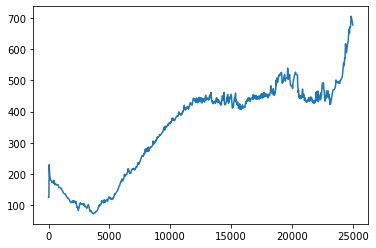

In [19]:
df=pd.read_csv("C:\\crs\\proj\\2019_DorianOBX\\WayneWright_flights\\CoreBx\\dune_line_2.csv",header = None)

xUTM=df.loc[:,0].values
yUTM=df.loc[:,1].values

xdune,ydune=UTM2Island(xUTM, yUTM, eoff=r['e0'], noff=r['n0'], rot=r['theta'])
# y = np.arange(0,nalong+1.)
f = interpolate.interp1d(xdune,ydune,bounds_error=False,fill_value=np.nan)
ydunei = f(xdist)

plt.plot(ydunei)

#### Read in the digitized profile for the back side at the ~1.25-m contour interval

Stat summary of island width (iswide)
  n, nnan, nvalid:  25000 0 25000
  mean, std, min, max   : 260.892 77.296 0.000 492.284
  d5, d25, d50, d75, d95: 130.494 213.562 262.624 313.341 377.522


Text(0, 0.5, 'Cross-shore distance (m)')

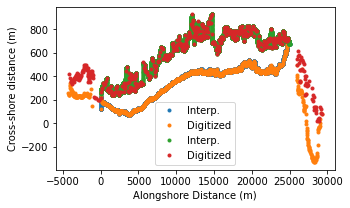

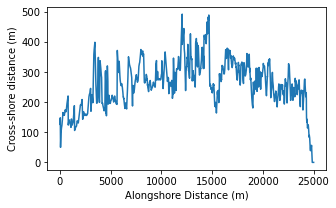

In [5]:
dfb=pd.read_csv("C:\\crs\\proj\\2019_DorianOBX\\WayneWright_flights\\CoreBx\\back_125_2.csv",header = None)
xUTMb=dfb.loc[:,0].values
yUTMb=dfb.loc[:,1].values

# rotate to alongshore/cross-shore coordinates
xback,yback=UTM2Island(xUTMb, yUTMb, eoff=r['e0'], noff=r['n0'], rot=r['theta'])

# interpolate
fb = interpolate.interp1d(xback,yback,bounds_error=False,fill_value=np.nan)
ybacki = fb(xdist)

# ensure back >= dune
ybacki[ybacki<ydunei]=ydunei[ybacki<ydunei]
iswide = ybacki-ydunei

print("Stat summary of island width (iswide)")
stat_summary(iswide,iprint=True)

fig = plt.figure(figsize=(5,3))
plt.plot(xdist,ydunei,'.',label="Interp.")
plt.plot(xdune,ydune,'.',label='Digitized')
plt.plot(xdist,ybacki,'.',label="Interp.")
plt.plot(xback,yback,'.',label='Digitized')
plt.legend()
plt.xlabel('Alongshore Distance (m)')
plt.ylabel('Cross-shore distance (m)')

fig = plt.figure(figsize=(5,3))
plt.plot(xdist,iswide,'-')
plt.xlabel('Alongshore Distance (m)')
plt.ylabel('Cross-shore distance (m)')

In [6]:
### Find seaward-most point. If not <= 0. mNAVD88, then extend beach

In [8]:
dist = np.arange(0.,ncross)
print(dist)

profile_list = range(0,nalong,1)
icross = np.zeros(nalong)
zinit = np.zeros(nalong)
del_vol = np.zeros(nalong)

nprofs = len(profile_list)
print(nprofs, profile_list)
dsaxb = dsaa.copy()
nmap = 0

[0.000e+00 1.000e+00 2.000e+00 ... 1.197e+03 1.198e+03 1.199e+03]
25000 range(0, 25000)


In [57]:
for i in range(1000):
    prof = np.squeeze(np.array((dsaa[nmap,:,i])))
    icross[i], zinit[i], del_vol[i], junk = extend_beach(dist, prof)
    print(i, icross[i], zinit[i], del_vol[1], np.shape(junk))


0 110.0 -0.14467088878154755 0.9391834735870361 (1200,)
p= 0.047132188081740585
changed slope to  0.05
1 102.0 0.04923811927437782 0.9391834735870361 (1200,)
2 109.0 -0.015977080911397934 0.9391834735870361 (1200,)
3 110.0 -0.2206224799156189 0.9391834735870361 (1200,)
4 110.0 -0.17171204090118408 0.9391834735870361 (1200,)
5 109.0 -0.0887347012758255 0.9391834735870361 (1200,)
6 110.0 -0.16637709736824036 0.9391834735870361 (1200,)
7 110.0 -0.11446177959442139 0.9391834735870361 (1200,)
8 110.0 -0.09235461056232452 0.9391834735870361 (1200,)
9 110.0 -0.04257557913661003 0.9391834735870361 (1200,)
10 110.0 -0.048449933528900146 0.9391834735870361 (1200,)
11 110.0 -0.16604730486869812 0.9391834735870361 (1200,)
12 111.0 -0.1556709110736847 0.9391834735870361 (1200,)
13 112.0 -0.12290018796920776 0.9391834735870361 (1200,)
14 112.0 -0.333647757768631 0.9391834735870361 (1200,)
15 111.0 -0.2106539011001587 0.9391834735870361 (1200,)
16 110.0 -0.26743096113204956 0.9391834735870361 (1200,)

195 104.0 -0.20156893134117126 0.9391834735870361 (1200,)
196 103.0 -0.07306019961833954 0.9391834735870361 (1200,)
197 103.0 -0.011835383251309395 0.9391834735870361 (1200,)
198 103.0 -0.011835383251309395 0.9391834735870361 (1200,)
199 104.0 -0.13673216104507446 0.9391834735870361 (1200,)
200 105.0 -0.09149186313152313 0.9391834735870361 (1200,)
201 104.0 -0.09327268600463867 0.9391834735870361 (1200,)
202 104.0 -0.16131910681724548 0.9391834735870361 (1200,)
203 105.0 -0.07285965979099274 0.9391834735870361 (1200,)
204 104.0 -0.2631596326828003 0.9391834735870361 (1200,)
205 103.0 -0.2631596326828003 0.9391834735870361 (1200,)
206 103.0 -0.17952531576156616 0.9391834735870361 (1200,)
207 103.0 -0.18836122751235962 0.9391834735870361 (1200,)
208 104.0 -0.1527974009513855 0.9391834735870361 (1200,)
209 104.0 -0.20193257927894592 0.9391834735870361 (1200,)
210 104.0 -0.24270394444465637 0.9391834735870361 (1200,)
211 103.0 -0.254793256521225 0.9391834735870361 (1200,)
212 104.0 -0.2669

p= 0.10054922029376114
369 107.0 0.05748036876320839 0.9391834735870361 (1200,)
p= 0.09358622431755129
370 107.0 0.000417172908782959 0.9391834735870361 (1200,)
p= 0.08859013542532995
371 107.0 0.031323958188295364 0.9391834735870361 (1200,)
p= 0.08124495372176091
372 106.0 0.018069010227918625 0.9391834735870361 (1200,)
p= 0.08572334349155343
373 106.0 0.0047290995717048645 0.9391834735870361 (1200,)
p= 0.08856921121478152
374 107.0 0.05277331545948982 0.9391834735870361 (1200,)
375 107.0 -0.015682321041822433 0.9391834735870361 (1200,)
376 107.0 -0.05510984733700752 0.9391834735870361 (1200,)
377 107.0 -0.10198980569839478 0.9391834735870361 (1200,)
378 107.0 -0.05758015066385269 0.9391834735870361 (1200,)
379 108.0 -0.010704083368182182 0.9391834735870361 (1200,)
380 107.0 -0.09262794256210327 0.9391834735870361 (1200,)
381 107.0 -0.09262794256210327 0.9391834735870361 (1200,)
382 106.0 -0.0777740627527237 0.9391834735870361 (1200,)
383 107.0 -0.03983277082443237 0.9391834735870361 

577 104.0 -0.08484834432601929 0.9391834735870361 (1200,)
p= 0.05245627798140086
578 103.0 0.011685594916343689 0.9391834735870361 (1200,)
579 104.0 -0.08080391585826874 0.9391834735870361 (1200,)
580 105.0 -0.11325216293334961 0.9391834735870361 (1200,)
581 105.0 -0.06313355267047882 0.9391834735870361 (1200,)
582 105.0 -0.11966955661773682 0.9391834735870361 (1200,)
583 104.0 -0.1418122798204422 0.9391834735870361 (1200,)
584 105.0 -0.13596439361572266 0.9391834735870361 (1200,)
585 105.0 -0.09219236671924591 0.9391834735870361 (1200,)
586 104.0 -0.05593223124742508 0.9391834735870361 (1200,)
587 105.0 -0.06304863095283508 0.9391834735870361 (1200,)
588 104.0 -0.10670992732048035 0.9391834735870361 (1200,)
589 104.0 -0.16704091429710388 0.9391834735870361 (1200,)
590 103.0 -0.10133926570415497 0.9391834735870361 (1200,)
591 104.0 -0.10133926570415497 0.9391834735870361 (1200,)
592 104.0 -0.19093546271324158 0.9391834735870361 (1200,)
593 105.0 -0.1826249361038208 0.9391834735870361 (

p= 0.10484887957573025
752 95.0 0.24946990609169006 0.9391834735870361 (1200,)
p= 0.07018924355506952
753 93.0 0.2893475890159607 0.9391834735870361 (1200,)
p= 0.10056883096695027
754 95.0 0.2661454379558563 0.9391834735870361 (1200,)
p= 0.06355560719966881
755 94.0 0.21832510828971863 0.9391834735870361 (1200,)
p= 0.06503934562206323
756 94.0 0.2906220853328705 0.9391834735870361 (1200,)
p= 0.08416633009910651
757 95.0 0.25207895040512085 0.9391834735870361 (1200,)
p= 0.10674175620079124
758 96.0 0.20731627941131592 0.9391834735870361 (1200,)
p= 0.10164166092872695
759 95.0 0.21118274331092834 0.9391834735870361 (1200,)
p= 0.07853504419326794
760 94.0 0.20337292551994324 0.9391834735870361 (1200,)
p= 0.07291094660758969
761 94.0 0.19416412711143494 0.9391834735870361 (1200,)
p= 0.09261441528797212
762 95.0 0.23310768604278564 0.9391834735870361 (1200,)
p= 0.05971715152263631
763 93.0 0.2176973819732666 0.9391834735870361 (1200,)
p= 0.08576437830924981
764 94.0 0.2279808223247528 0.939

p= 0.0772972673177715
951 83.0 0.028254561126232147 0.9391834735870361 (1200,)
p= 0.06439171731471977
952 82.0 0.09208214282989502 0.9391834735870361 (1200,)
p= 0.06693597733974409
953 82.0 0.10603705048561096 0.9391834735870361 (1200,)
p= 0.0757485844194885
954 83.0 0.04113307222723961 0.9391834735870361 (1200,)
p= 0.0695713903754949
955 82.0 0.0021796822547912598 0.9391834735870361 (1200,)
p= 0.07439734116196627
956 82.0 0.010492701083421707 0.9391834735870361 (1200,)
p= 0.07159335725009433
957 82.0 0.017477963119745255 0.9391834735870361 (1200,)
p= 0.08427695110440196
958 83.0 0.05654336139559746 0.9391834735870361 (1200,)
p= 0.06919804215431206
959 82.0 0.01025504618883133 0.9391834735870361 (1200,)
p= 0.07242244705557817
960 82.0 0.03249932453036308 0.9391834735870361 (1200,)
p= 0.08599878549575753
961 82.0 0.09357406198978424 0.9391834735870361 (1200,)
p= 0.0961822718381875
962 83.0 0.0949036180973053 0.9391834735870361 (1200,)
p= 0.07497564107179633
963 82.0 0.07022921741008759 

#### Make a copy of the elevation array and smooth / hole fill with astropy

In [ ]:
%%time
kernel5 = Gaussian2DKernel(x_stddev=.5)
kernel9 = Gaussian2DKernel(x_stddev=1.)
print('Shape of kernel5: ',np.shape(kernel5))
print('Shape of kernel9: ',np.shape(kernel9))
dsss = np.ones_like(dsaa)
for imap in range(nmaps):
    # astropy convolve will fill NaN holes
    dsss[imap,:,:] = astropy_convolve(dsaa[imap,:,:],kernel5)
    dsss_flat = np.ravel(dsss[imap,:,:])
    dsaa_flat = np.ravel(dsaa[imap,:,:])
    dsaa_flat[np.where(np.isnan(dsaa_flat))]=dsss_flat[np.where(np.isnan(dsaa_flat))]

In [ ]:
print(np.shape(dsaa))
print(np.shape(dsaa.ravel()))

In [ ]:
# yss = 10000
# dxx = 1000
# dyy = 1000
# imap = 1
# xss = 0
yss = 10000
dxx = 700
dyy = 700
imap = 1
xss = 250
xse = xss+dxx
yse = yss + dyy

# This makes NaN gray
ncmap=cmap_ncb
ncmap.set_bad(color='black')

fix, axes = plt.subplots(2,2,figsize=(15,15),sharey='row')
axes[0,0].pcolormesh(dsaa[imap,xss:xse,yss:yse],vmin=-1,vmax=8,cmap=ncmap)
axes[0,0].set_title('Initial map')
axes[0,1].pcolormesh(dsaa[imap,xss:xse,yss:yse],vmin=-1,vmax=8,cmap=ncmap)
axes[0,1].set_title('Same map')
axes[1,0].pcolormesh(dsss[imap,xss:xse,yss:yse],vmin=-1,vmax=8,cmap=ncmap)
axes[1,0].set_title('Smoothed keeping NaNs')
axes[1,1].pcolormesh(dssn[imap,xss:xse,yss:yse],vmin=-1,vmax=8,cmap=ncmap)
axes[1,1].set_title('Smoothed removing NaNs')


### Make 3D difference array

In [ ]:
dsdif = np.diff(dsaa,1,0)
print(np.shape(dsdif))

In [ ]:
# This is a test map + profile figure that can be relocated

figdir = 'C:/crs/proj/2019_DorianOBX/Dorian_paper_analyses/figs/'

yss = 10000
dxx = 400
dyy = 1000
imap = 0
xss = 200
xse = xss+dxx
yse = yss + dyy

figname = 'prof_map{:d}_{:d}'.format(imap,yss)
dvol = np.nansum(dsdif[imap,xss:xse,yss:yse])
ts = '$\Delta$ Vol. = {:.0f} m$^3$'.format(dvol)
yticks = np.arange(xss,xse+dxx,200)
xticks = np.arange(yss,yse+dyy,200)

fix, axes = plt.subplots(1,3,figsize=(15,4),sharey='row')
axes[0].pcolormesh(dsaa[imap,xss:xse,yss:yse],vmin=0.0,vmax=.07)
axes[1].pcolormesh(dsaa[imap,xss:xse,yss:yse],vmin=-1,vmax=6,cmap=cmap_ncb)
axes[2].pcolormesh(dsdif[imap,xss:xse,yss:yse],vmin=-5,vmax=5,cmap=dcmap)
for i in range(0,3):
    yvals = np.ones(2)*(i+1)*int(dyy/4)
    xvals = np.array((0.,dxx))
    print(xvals, yvals)
    axes[0].plot(yvals,xvals,'--',c='gray')
    axes[1].plot(yvals,xvals,'--',c='gray')
    axes[2].plot(yvals,xvals,'--',c='gray')
    axes[i].set_xticklabels(xticks)
   
axes[0].text(.05,.9,'a) $E$ '+dates[imap],transform=axes[0].transAxes)
axes[1].text(.05,.9,'b) $z$ '+dates[imap],transform=axes[1].transAxes)
axes[2].text(.05,.9,'c) '+ts,transform=axes[2].transAxes)
axes[0].set_yticklabels(yticks)
axes[0].set_ylabel('Cross-shore Distance (m)')
axes[1].set_xlabel('Alongshore Distance (m)')
plt.savefig(figdir+'map_'+figname+'.jpg',dpi=200)

fig, axes = plt.subplots(3,1,figsize=(15,4),sharex=True)
for i, ax in enumerate(axes):
    izz,izc,izip,zz,zc,zipt = find_toe(ydist[xss:xse],np.squeeze(dsaan[imap,xss:xse,  yss+(i+1)*int(dyy/4)]))
    ax.plot(ydist[izc],zc,'o')
    print('dist,zc: ',ydist[izc],zc)
    ax.plot(ydist[xss:xse],np.squeeze(dsaan[imap,xss:xse,  yss+(i+1)*int(dyy/4)]))
#     ax.plot(np.squeeze(dsaan[imap,xss:xse,  yss+(i+1)*int(dyy/4)]),c=blue5[2],label='$z$ '+dates[imap])
#     ax.plot(np.squeeze(dsaan[imap+1,xss:xse,yss+(i+1)*int(dyy/4)]),c=purple5[2],label='$z$ '+dates[imap+1])
#     ax.plot(np.squeeze(dssn[imap,xss:xse,  yss+(i+1)*int(dyy/4)]),c=blue5[4],label='$zs$ '+dates[imap])
#     ax.plot(np.squeeze(dssn[imap+1,xss:xse,yss+(i+1)*int(dyy/4)]),c=purple5[4],label='$zs$ '+dates[imap+1])
#     ax.plot(np.squeeze(erat[imap,xss:xse,   yss+(i+1)*int(dyy/4)]),c=red3[2],alpha=0.4,label='$E$ '+dates[imap])
#     ax.plot(np.squeeze(erat[imap+1,xss:xse, yss+(i+1)*int(dyy/4)]),c=red3[1],alpha=0.4,label='$E$ '+dates[imap+1])
#     ax.set_ylim((-1.,5.))

axes[2].legend(loc='upper right')
ttext = 'Cross-shore Profiles, map{}, Alongshore {:0d}'.format(imap,yss)
axes[0].set_title(ttext)
axes[-1].set_xlabel('Cross-shore Distance (m)')
axes[1].set_ylabel('Elevation (m NAVD88')
plt.savefig(figdir+'prof_'+figname+'.svg',dpi=200)


#### Single profile for tests

In [ ]:
%run -i CoreBx_funcs # used to update when debugging the funcs

#iprof = 17550
#iprof = 35999
iprof = 7000
title_str = 'test pvol'
pnames=['28-Aug','13-Sep','11-Oct','26-Nov']
datum = 0.4 

nprofs = 1

# allocate arrays for profile info
y = np.zeros(nprofs)
v = np.zeros((nmaps,nprofs))
vp = np.zeros((nmaps,nprofs))
vb = np.zeros((nmaps,nprofs))
cxcy = np.zeros((nmaps,nprofs,2))
zmax = v.copy()
dmax = v.copy()
zmax = v.copy()
dmax = v.copy()
zcrest = v.copy()
dcrest = v.copy()
zcrest0 = v.copy()
dtoe_zc = v.copy()
ztoe_zc = v.copy()
width_island = v.copy()
width_platform = v.copy()
width_beach = v.copy()

maxdist = 100.
proff = np.squeeze(np.array((dsaa[:,:,iprof])))
#pfill = np.squeeze(np.array((dsfa[:,iprof])))
psmooth = np.squeeze(np.array((dssn[:,:,iprof])))

title_str = '%s_Profile_%s' % (r['name'].capitalize(),iprof)
#title_str = '{0}_Profile_{1}'.format(r['name'].capitalize(),iprof)
i=0
print(i,y[i],ydune[i])

imap = 0
y = ydist[xss:xse]
p = proff[0,xss:xse]

izz,izc,izip,zz,zc,zipt = find_toe(ydist[xss:xse],np.squeeze(proff[0,xss:xse]),debug=True)
    #ax.plot(ydist[izc],zc,'o')
print(izz,izc,izip)
# print('dist,zc: ',ydist[izc],zc)
# print('dist,zz: ',ydist[izz],zz)
# print('dist,zipt: ',ydist[izipt],zipt)

    #ax.plot(ydist[xss:xse],np.squeeze(dsaan[imap,xss:xse,  yss+(i+1)*int(dyy/4)]))


# v[:,i], vp[:,i], vb[:,i], cxcy[:,i,:], zmax[:,i], dmax[:,i], zcrest[:,i], dcrest[:,i], zcrest0[:,i], dtoe_zc[:,i],\
#     ztoe_zc[:,i],width_island[:,i], width_platform[:,i], width_beach[:,i] = \
#       pvol(ydist,proff,pfill,psmooth,ydunei[iprof],ybacki[iprof],\
#       title_str,pnames,imethod='extend',\
#       datum=datum,\
#       maxdist=maxdist,ztoe=2.4,zowp=1.25,nsmooth=51,\
#       iverbose=True,iplot=True,iprint=True)

### Analyze each map using a profile approach
* Load `CoreBx_funcs.py`
* Loop through the four maps and call `pvol` func

In [ ]:
%%time
%run -i CoreBx_funcs # used to update when debugging the funcs

# process all of them
dist = np.arange(0,ncross)
title_str = 'test pvol'
pnames=dates
datum = 0.4 

profile_list = range(0,nalong,1)
nprofs = len(profile_list)
print(nprofs, profile_list)

y = np.arange(0.,nalong)
# allocate arrays for profile info
v = np.zeros((nmaps,nprofs))
vp = np.zeros((nmaps,nprofs))
vb = np.zeros((nmaps,nprofs))
cxcy = np.zeros((nmaps,nprofs,2))
zmax = v.copy()
dmax = v.copy()
zmax = v.copy()
dmax = v.copy()
zcrest = v.copy()
dcrest = v.copy()
zcrest0 = v.copy()
dtoe_zz = v.copy()
ztoe_zz = v.copy()
dtoe_zc = v.copy()
ztoe_zc = v.copy()
dtoe_ip = v.copy()
ztoe_ip = v.copy()
width_island = v.copy()
width_platform = v.copy()
width_beach = v.copy()

maxdist = 100.  #starting distance for profiles
for i, iprof in enumerate(profile_list):
    proff = np.squeeze(np.array((dsaa[:,:,iprof])))
    pfill = np.squeeze(np.array((dsfa[:,iprof])))

    title_str = '{0}_Profile_{1}'.format(r['name'].capitalize(),iprof)

    # dunes are farther back in NE portion
    if y[i] >=25000:
        maxdist = 200.
    v[:,i], vp[:,i], vb[:,i], cxcy[:,i], zmax[:,i], dmax[:,i], zcrest[:,i], dcrest[:,i], zcrest0[:,i],\
    dtoe_zz[:,i], ztoe_zz[:,i], dtoe_zc[:,i], ztoe_zc[:,i], dtoe_ip[:,i], ztoe_ip[:,i],\
    width_island[:,i], width_platform[:,i], width_beach[:,i] = \
          pvol(dist, proff, pfill, ydunei[iprof], ybacki[iprof],\
          title_str, pnames, imethod='extend',\
          datum=datum,\
          maxdist=maxdist,ztoe=2.4,zowp=1.25,nsmooth=51,\
          iverbose=False,iplot=False,iprint=False)


In [ ]:
#TODO - Do all months, maybe add other variables
# put these results in a .csv file via Pandas
for i, mnth in enumerate(['Aug_','Sep_','Oct_','Nov_']):
    exec( mnth+"pmetrics = pd.DataFrame({'y':y.T,'Vol':v[i,:],'Volp':vp[i,:],'Cx':cxcy[i,:,0],'Cy':cxcy[i,:,1],\
        'zmax':zmax[i,:], 'dmax':dmax[i,:], 'zcrest':zcrest[i,:], 'dcrest':dcrest[i,:], 'zcrest0':zcrest0[i,:],\
        'dtoe':dtoe[i,:],'iwidth':width_island[i,:],'pwidth': width_platform[i,:]})" )
    exec(mnth+"pmetrics.to_csv('"+mnth+"_pmetrics.csv',index=False,na_rep='-999.999',float_format='%.3f')")

In [ ]:

plt.plot(y,vp[0,:],'.')
plt.plot(y,vp[1,:],'.')

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(y,vp[1,:]-vp[0,:],'.')

In [ ]:
plt.plot(y,width_platform[0,:])
plt.plot(y,width_platform[1,:])

In [ ]:
plt.plot(y,dcrest[0,:])
plt.plot(y,dcrest[3,:])

### Volume calcs

In [ ]:
vp_tot = np.nansum(vp,1)
vb_tot = np.nansum(vb,1)
ap_tot = np.nansum(width_platform,1)
ab_tot = np.nansum(width_beach,1)
print('Date       Plat vol Beach vol  P area   B area     Frac. Elev.')
for i, d in enumerate(dates):
    print('{} {:.0f} {:.0f}   {:.0f}  {:.0f}  {:.3f}  {:.2f}'.format(dates[i],vp_tot[i],vb_tot[i],ap_tot[i],ab_tot[i],vp_tot[i]/vp_tot[0],vp_tot[i]/ap_tot[i]))

### Volume Calc Uncertainty

In [ ]:
# print statement have been commented out...better output formats in pandas output
# for platform volumes
sigma_rs = np.ones_like(vp_tot)*np.nan
sigma_sc = sigma_rs.copy()
# for beach volumes
sigma_rsb = sigma_rs.copy()
sigma_scb = sigma_rs.copy()
sigma_rmsd = np.sqrt(2.*0.2**2)
print('sigma_rmsd:',sigma_rmsd)

L2 = 1. # 1-m grid
for imap in range((nmaps)):

    # Uncorrelated random error
    an = ap_tot[imap] # approximate area
    bn = ab_tot[imap]
    #print('areas:', an, bn)
    sigma_rs[imap] = sigma_rmsd/np.sqrt(an)
    sigma_rsb[imap] = sigma_rmsd/np.sqrt(bn)

    # Spatially correlated data (max values)
    sill = np.sqrt(0.03)
    sigma_sill = np.sqrt(sill)
    rng = 360.
    sigma_sc[imap] = (sigma_sill/np.sqrt(an)) * np.sqrt((np.pi*rng**2)/(5.*L2))
    sigma_scb[imap] = (sigma_sill/np.sqrt(bn)) * np.sqrt((np.pi*rng**2)/(5.*L2))

    Asc = np.pi*rng**2/(5.*an*L2)
    Ascb = np.pi*rng**2/(5.*bn*L2)

    #print('Asc: ',Asc, Ascb)
    
# Systematic error
sigma_sys = 0.07

# total error
sigma_tot = np.sqrt( sigma_rs**2. + sigma_sc**2. + sigma_sys**2.)
sigma_totb = np.sqrt( sigma_rsb**2. + sigma_scb**2. + sigma_sys**2.)

for i in range(nmaps-1):
    # calculate stats for platform and beach widths
    ss=stat_summary(width_platform[i,:],iprint=False)
    ssb=stat_summary(width_beach[i,:],iprint=False)
#     print('Platform and beach median widths: {:.3f}, {:.3f}'.format(ss['d50'],ssb['d50']))
#     print('sigma_rs:           {:.6f}, {:.6f}'.format(sigma_rs[i], sigma_rsb[i]))
#     print('sigma_sc:           {:.6f}, {:.6f}'.format(sigma_sc[i], sigma_scb[i]))
#     print('sigma_tot:          {:.6f}, {:.6f}'.format(sigma_tot[i], sigma_totb[i]))

# print('ap_tot: ',ap_tot)
# print('vp_tot: ',vp_tot)
# print('avg. elevation: ',vp_tot/ap_tot)
vdiff = np.diff(vp_tot,1,0)
# print('diff(vp_tot):',vdiff)
# print('diff as fraction of initial volume: ',vdiff/vp_tot[0])
# print('diff per meter',vdiff/36650.)
err = ap_tot*sigma_tot
errb = ab_tot*sigma_totb

# print('err volumes',err,errb)
# print('err as frac of volume initial volume: ',err/vp_tot[0])
# print('err as frac of volume change:',np.mean(err)/vdiff)
# print('avg. elevation change: ',vdiff/np.mean(ap_tot))

### Put results in a Pandas dataframe

In [ ]:
pd.set_option("display.precision", 2)
df = pd.DataFrame({'Date':dates,
                   'Platform Vol. (Mm3)':vp_tot/1e6,
                   'Beach Vol. (Mm3)': vb_tot/1e6,
                   'Total Vol. (Mm3)': (vb_tot+vp_tot)/1e6,
                   'Platform Area (Mm2)':ap_tot/1e6,
                   'Beach Area (Mm2)':ab_tot/1e6,
                   'Total Area (Mm2)':(ap_tot+ab_tot)/1e6,
                   'Frac. Plat. Vol.':vp_tot/vp_tot[0],
                   'Frac. Beach. Vol.':vb_tot/vb_tot[0],
                   'Frac. Tot. Vol.':(vb_tot+vp_tot)/(vb_tot[0]+vp_tot[0]),
                   'Frac. Err. Plat. Vol.':err/vp_tot,
                   'Frac. Err. Beach Vol.':errb/vb_tot,
                   'Frac. Err. Tot. Vol.':(err+errb)/(vp_tot+vb_tot)
                  })
df

In [ ]:
df_stats = df.describe()
df_stats

In [ ]:
print("Summary in words:\n")
print('Initial island total (beach + platform) volume was {:.1f} Mm3, covering an area of {:.1f} Mm2, so the mean island elevation was {:.2f} m.'
      .format((vp_tot[0]+vb_tot[0])/1e6, (ap_tot[0]+ab_tot[0])/1e6,(vp_tot[0]+vb_tot[0])/(ap_tot[0]+ab_tot[0])))
ss=stat_summary((err+errb)/(vp_tot+vb_tot),iprint=False)
print('Uncertainties about the volume measurements range from {:.0f}% to {:.0f}% with a median value of {:.0f}%.'
     .format(100*ss['min'],100*ss['max'],100*ss['d50']))

dvp = np.diff(vp_tot)
dvpf = dvp/vp_tot[0]
err_pct = np.abs(100*np.sqrt(err[0:-1]**2+err[1:]**2)/dvp)

print('\nVolume changes relative to the initial platform volume of {:.2f} Mm3 in {} were {:.0f} m3, {:.0f} m3, and {:.0f} m3 for surveys on {}, {}, and {}, respectively.'
     .format(vp_tot[0]/1e6,dates[0],dvp[0],dvp[1],dvp[2],dates[1],dates[2],dates[3]))
print('These are fractional changes of {:.2f}, {:.3f}, and {:.2f} of inital platform volume.'
     .format(dvpf[0],dvpf[1],dvpf[2]))
print('Uncertainties around these changes are {:.0f}%, {:.0f}%, and {:.0f}%.'
      .format(err_pct[0], err_pct[1], err_pct[2]))

dvb = np.diff(vb_tot)
dvbf = dvb/vb_tot[0]
errb_pct = np.abs(100*np.sqrt(errb[0:-1]**2+errb[1:]**2)/dvb)

print('\nVolume changes relative to the initial beach volume in {} were {:.0f} m3, {:.0f} m3, and {:.0f} m3 for surveys on {}, {}, and {}, respectively.'
     .format(dates[0],dvb[0],dvb[1],dvb[2],dates[1],dates[2],dates[3]))
print('These are fractional changes of {:.2f}, {:.2f}, and {:.2f} of inital beach volume.'
     .format(dvbf[0],dvbf[1],dvbf[2]))
print('Uncertainties around these changes are {:.0f}%, {:.0f}%, and {:.0f}%.'
      .format(errb_pct[0], errb_pct[1], errb_pct[2]))

### Plot  volumes through Nov 2019

In [ ]:
# make a datetime array
dtl = []
for date in dates:
    dtl.append(datetime.strptime(date, "%Y-%m-%d"))
dt = np.array(dtl)

fig, ax = plt.subplots(1,1,figsize=(5,5))
fig.autofmt_xdate()
#plt.plot(dt,vsumall/1e6,label="Entire island")
errt = np.sqrt(err**2+errb**2)

vol0 = vp_tot[0]+vb_tot[0]*np.ones_like(vp_tot)
volp0 = vp_tot[0]*np.ones_like(vp_tot)

# # full recovery of total volume
# plt.fill_between(dt[0:4], vol0[0:4]/1e6, (vol0[0:4]-.05*vol0[0:4])/1e6, color='lightgray')
# plt.plot(dt[0:4], vol0[0:4]/1e6,'--',c=cols[4],linewidth=3)

# # full recovery of platform
# plt.fill_between(dt[0:4], volp0[0:4]/1e6, (volp0[0:4]-.05*vol0[0:4])/1e6, color='lightgray')
# plt.plot(dt[0:4],(volp0[0:4])/1e6,'--',c=cols[3],linewidth=3)

# total
plt.fill_between(dt[0:4], (vp_tot[0:4]+vb_tot[0:4]+errt[0:4])/1e6, (vp_tot[0:4]+vb_tot[0:4]-errt[0:4])/1e6,color=cols[0] )
plt.plot(dt[0:4],(vp_tot[0:4]+vb_tot[0:4])/1e6,label="Total volume",c=cols[4],linewidth=3)
plt.plot(dt[0:4],(vp_tot[0:4]+vb_tot[0:4])/1e6,'o',c=cols[4])
# platform
plt.fill_between(dt[0:4], (vp_tot[0:4]+err[0:4])/1e6, (vp_tot[0:4]-err[0:4])/1e6,color=cols[0] )
plt.plot(dt[0:4],(vp_tot[0:4])/1e6,label="Platform volume",c=cols[3],linewidth=3)
plt.plot(dt[0:4],(vp_tot[0:4])/1e6,'o',c=cols[4])
# beach
plt.fill_between(dt[0:4], (vb_tot[0:4]+errb[0:4])[0:4]/1e6, (vb_tot[0:4]-errb[0:4])/1e6,color=cols[0] )
plt.plot(dt[0:4],vb_tot[0:4]/1e6,label="Beach volume",c=cols[2],linewidth=3)
plt.plot(dt[0:4],(vb_tot)[0:4]/1e6,'o',c=cols[4])

plt.ylabel('Million m$^3$')
plt.grid()
plt.legend()
#plt.title('Island Volume')
fig_name = 'island_volume_2019.svg'
plt.savefig(fig_name,bbox_inches='tight', format='svg')
fig_name = 'island_volume_2019.png'
plt.savefig(fig_name,bbox_inches='tight', format='png', dpi = 200)

In [ ]:
dates

### Plot  volumes for entire time series

In [ ]:
dtl = []
for date in dates:
    dtl.append(datetime.strptime(date, "%Y-%m-%d"))
dt = np.array(dtl)

fig, ax = plt.subplots(1,1,figsize=(5,5))
fig.autofmt_xdate()
#plt.plot(dt,vsumall/1e6,label="Entire island")
errt = np.sqrt(err**2+errb**2)

vol0 = vp_tot[0]+vb_tot[0]*np.ones_like(vp_tot)
volp0 = vp_tot[0]*np.ones_like(vp_tot)

# full recovery of total volume
plt.fill_between(dt, vol0/1e6, (vol0-.05*vol0)/1e6, color='lightgray')
plt.plot(dt,(vol0)/1e6,'--',c=cols[4],linewidth=3)

# full recovery of platform
plt.fill_between(dt, volp0/1e6, (volp0-.05*vol0)/1e6, color='lightgray')
plt.plot(dt,(volp0)/1e6,'--',c=cols[3],linewidth=3)

# total
plt.fill_between(dt, (vp_tot+vb_tot+errt)/1e6, (vp_tot+vb_tot-errt)/1e6,color=cols[0] )
plt.plot(dt,(vp_tot+vb_tot)/1e6,label="Total volume",c=cols[4],linewidth=3)
plt.plot(dt,(vp_tot+vb_tot)/1e6,'o',c=cols[4])
# platform
plt.fill_between(dt, (vp_tot+err)/1e6, (vp_tot-err)/1e6,color=cols[0] )
plt.plot(dt,(vp_tot)/1e6,label="Platform volume",c=cols[3],linewidth=3)
plt.plot(dt,(vp_tot)/1e6,'o',c=cols[4])
# beach
plt.fill_between(dt, (vb_tot+errb)/1e6, (vb_tot-errb)/1e6,color=cols[0] )
plt.plot(dt,vb_tot/1e6,label="Beach volume",c=cols[2],linewidth=3)
plt.plot(dt,(vb_tot)/1e6,'o',c=cols[4])

plt.ylabel('Million m$^3$')
plt.grid()
plt.legend()
#plt.title('Island Volume')
fig_name = 'island_volume.svg'
plt.savefig(fig_name,bbox_inches='tight', format='svg')
fig_name = 'island_volume.png'
plt.savefig(fig_name,bbox_inches='tight', format='png', dpi = 200)

### Plot beach area and volume for the entire dataset

In [ ]:

fig, ax = plt.subplots(1,1,figsize=(5,5))
fig.autofmt_xdate()
plt.plot(dt,ab_tot/1e6,linewidth=3,label='Area (Mm$^2$)')
plt.plot(dt,vb_tot/1e6,linewidth=3,label='Volume (Mm$^3$)')
plt.legend()
plt.ylabel('Area, Volume',fontsize=14)

### Plot beach volume and area

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
fig.autofmt_xdate()
plt.plot(dt,ab_tot/ab_tot[0],linewidth=3,label='Area')
plt.plot(dt,vb_tot/vb_tot[0],linewidth=3,label='Volume')
plt.ylabel('Relative Beach Area, Volume',fontsize=14)
plt.legend()

### Simple platform volume plot

In [ ]:
dtl = []
for date in dates:
    dtl.append(datetime.strptime(date, "%Y-%m-%d"))
dt = np.array(dtl)

fig, ax = plt.subplots(1,1,figsize=(8,4))
fig.autofmt_xdate()
#plt.plot(dt,vsumall/1e6,label="Entire island")
#plt.fill_between(dt, (vp_tot+err)/1e6, (vp_tot-err)/1e6,color=cols[0] )
plt.plot(dt,(vp_tot-vb_tot)/1e6,label="Platform volume",c=cols[3],linewidth=3)
plt.grid()
plt.legend()
#plt.title('Island Volume')
fig_name = 'simple_platform_volume.svg'
plt.savefig(fig_name,bbox_inches='tight', format='svg')
fig_name = 'simple_platform_volume.png'
plt.savefig(fig_name,bbox_inches='tight', format='png', dpi = 200)

In [ ]:
# average elevation (alongshore)
melev = vp / width_platform
print('Shape of alongshore mean elevation: ',np.shape(melev))
# average elevation difference
melev_diff = np.diff(melev,1,0)
print('Shape of elevation difference: ',np.shape(melev_diff))
for i in range(nmaps-1):
    sstat=stat_summary(melev_diff[i,:],iprint=False)
    print('d50: ',sstat['d50'],'mean',sstat['mean'])

### Island-wide max. elevation, volume, and average elevation

In [ ]:
# mean profile elevations
pelev = vp / width_platform
pelev_diff = np.diff(pelev,1,0)
print("Shape of pelev:",np.shape(pelev))

aug_mean_elev = np.nanmean(pelev[0,:])
aug_std_elev = np.nanstd(pelev[0,:])
aug_err=np.sqrt(aug_std_elev**2+0.08**2)

sep_mean_elev = np.nanmean(pelev[1,:])
sep_std_elev = np.nanstd(pelev[1,:])
sep_err=np.sqrt(sep_std_elev**2+0.08**2)

diff_mean = np.nanmean(pelev_diff[0,:])
diff_std = np.nanmean(pelev_diff[0,:])
diff_err1 = np.sqrt(diff_std**2 + 0.08**2 + 0.08**2)
diff_err2 = np.sqrt(aug_err**2+sep_err**2+ 0.08**2 + 0.08**2)

print('August mean elev: {:.2f} Std: {:.2f} Err: {:.2f}'.format(aug_mean_elev,aug_std_elev,aug_err))
print('Sept mean elev: {:.2f} Std: {:.2f} Err: {:.2f}'.format(sep_mean_elev,sep_std_elev,sep_err))
print('Sept minus Aug elev diff: {:.2f} Std: {:.2f} Err1: {:.2f} Err2: {:.2f}'.format(diff_mean,diff_std,diff_err1,diff_err2))

In [ ]:
# smooth mean profiles
pelev0s = running_mean(pelev[0,:],501)
pelev1s = running_mean(pelev[1,:],501)
pelev1sd = running_stddev(pelev[1,:],501)
pelev_diff1s = running_mean(pelev_diff[0,:],501)

print("Stats for max elevations in August zmax[0,:]:")
s = stat_summary( zmax[0,:], iprint=True)
print("Stats for mean elevations in August pelev[0,:]:")
s = stat_summary( pelev[0,:], iprint=True)
# Elevation difference uncertainty
z_err = np.sqrt( s['std']**2 + .08**2 )
print("Aug mean elevation = {:.2f} +/- {:.2f} (inluding mapping precision error)".format(s['mean'], z_err))
print("Stats for mean elevations in Sep pelev[1,:]:")
s = stat_summary( pelev[1,:], iprint=True)
# Elevation difference uncertainty
z_err = np.sqrt( s['std']**2 + .08**2 )
print("Sep mean elevation = {:.2f} +/- {:.2f} (inluding mapping precision error)".format(s['mean'], z_err))
print("Stats for mean elevation diffs in Sep minus Aug pelev_diff1s:")
s = stat_summary( pelev_diff1s, iprint=True)
# Elevation difference uncertainty
dz_err = np.sqrt( s['std']**2 + .08**2 + .08**2)
print("Mean elevation difference = {:.2f} +/- {:.2f} (inluding mapping precision error)".format(s['mean'], dz_err))

In [ ]:
# island width is wrong in places with no island volume
# TODO: maybe fix this in profile calcs?
width_platform0=width_platform.copy()
width_platform0[vp<=10.]=0.

# average volume
vpmean = np.zeros_like(vp)
vpstd = vpmean.copy()
apmean = vpmean.copy()
apstd = vpmean.copy()

# smooth volumes and widths
for i in range(0,4):
    vpmean[i,:] = running_nanmean(vp[i,:],501)
    vpstd[i,:] = running_stddev(vp[i,:],501)
    apmean[i,:] = running_nanmean(width_platform0[i,:],501)
    apstd[i,:] = running_stddev(width_platform0[i,:],501)

# smooth max elevations in August
x = zmax[0,:]
xs = running_nanmean(x,501)
xstd = running_stddev(x,501)
print(np.shape(x),np.shape(xs))

#vp_err = np.sqrt( vpstd**2 + (width_platform*np.tile(sigma_tot,[nalong,1]).T)**2 ) 

plt.figure(figsize=(12,12))
ax1=plt.subplot(311)
plt.plot(y,np.ones_like(y)*2.5,'--',c='gray')
plt.plot(y,xs,'-',linewidth=3,c=red3[2],label='Aug max')
ax1.fill_between(y,xs-xstd,xs+xstd,color=red3[0])
plt.plot(y,pelev0s,linewidth=3,c=cols[1],label='Aug mean')
plt.plot(y,pelev1s,linewidth=3,c=cols[2],label='Sep mean')
ax1.fill_between(y,pelev1s-pelev1sd,pelev1s+pelev1sd,color=cols[0])
plt.ylim((-2,8))
plt.text(0.02, 0.92,'a',horizontalalignment='left',verticalalignment='center',transform = ax1.transAxes, fontweight='bold')
plt.legend(loc='lower left')
plt.ylabel('Elevation (m NAVD88)')
plt.xlim((0,36500))

ax2=plt.subplot(312)
plt.plot(y,np.ones_like(y)*0.,'--',c='gray')
plt.plot(y,vpmean[0,:],linewidth=3,c=cols[2],label='Aug')
plt.plot(y,vpmean[1,:],linewidth=3,c=cols[3],label='Sep')
ax2.fill_between(y,vpmean[0,:]-vpstd[0,:],vpmean[0,:]+vpstd[0,:],color=cols[0])
ax2.fill_between(y,vpmean[1,:]-vpstd[1,:],vpmean[1,:]+vpstd[1,:],color=cols[0])
plt.text(0.02, 0.92,'b ',horizontalalignment='left',verticalalignment='center',transform = ax2.transAxes, fontweight='bold')
#plt.ylim((-2,8))
plt.ylabel('Volume (m$^3$/m)')
plt.legend(loc='lower left')
plt.xlim((0,36500))
#plt.xlabel('Alongshore distance (m)')

ax3=plt.subplot(313)
plt.plot(y,np.ones_like(y)*0.,'--',c='gray')
plt.plot(y,apmean[0,:],linewidth=3,c=cols[2],label='Aug')
plt.plot(y,apmean[1,:],linewidth=3,c=cols[3],label='Sep')
ax3.fill_between(y,apmean[0,:]-apstd[0,:],apmean[0,:]+apstd[0,:],color=cols[0])
ax3.fill_between(y,apmean[1,:]-apstd[1,:],apmean[1,:]+vpstd[1,:],color=cols[0])
plt.text(0.02, 0.92,'c ',horizontalalignment='left',verticalalignment='center',transform = ax3.transAxes, fontweight='bold')
#plt.ylim((-2,8))
plt.ylabel('Platform width (m)')
plt.legend(loc='lower left')
plt.xlim((0,36500))
plt.xlabel('Alongshore distance (m)')

fig_name = 'island_crest_vol_area.svg'
plt.savefig(fig_name,bbox_inches='tight', format='svg')
fig_name = 'island_crest_vol_area.png'
plt.savefig(fig_name,bbox_inches='tight', format='png', dpi = 200)

### Stats and plots for volume change

In [ ]:
# volume change plots
# average volume
dvmean = np.diff(vp,axis=0)
dvstd = np.nanstd(dvmean,axis=0)
dverr = np.sqrt(dvstd**2+0.08**2+0.08**2)

dvmeans = running_nanmean(dvmean[0,:],501)
dverrs = running_stddev(dverr,501)

print("Stats for volume change:")
s = stat_summary( dvmean[0,:], iprint=True)
print("Stats for volume change uncertainty:")
s = stat_summary( dverr, iprint=True)

plt.plot(dverrs)


### Plot of volume and volume change (two panel) `island_volume_change`

In [ ]:
ax1=plt.subplot(211)
plt.plot(y,np.ones_like(y)*0.,'--',c='gray')
plt.plot(y,vpmean[0,:],linewidth=3,c=cols[2],label='Aug')
plt.plot(y,vpmean[1,:],linewidth=3,c=cols[3],label='Sep')
ax1.fill_between(y,vpmean[0,:]-vpstd[0,:],vpmean[0,:]+vpstd[0,:],color=cols[0])
ax1.fill_between(y,vpmean[1,:]-vpstd[1,:],vpmean[1,:]+vpstd[1,:],color=cols[0])
plt.text(0.02, 0.92,'a ',horizontalalignment='left',verticalalignment='center',transform = ax1.transAxes, fontweight='bold')
#plt.ylim((-2,8))
plt.ylabel('Volume (m$^3$/m)')
plt.legend(loc='center left')
plt.xlim((0,36500))
#plt.xlabel('Alongshore distance (m)')

ax2=plt.subplot(212)
plt.plot(y,np.ones_like(y)*0.,'--',c='gray')
plt.plot(y,dvmeans,linewidth=3,c=cols[2],label='Sep - Aug')
#plt.plot(y,apmean[1,:],linewidth=3,c=cols[3],label='Sep')
ax2.fill_between(y,dvmeans-dverrs,dvmeans+dverrs,color=cols[0])
#ax2.fill_between(y,apmean[1,:]-apstd[1,:],apmean[1,:]+vpstd[1,:],color=cols[0])
plt.text(0.02, 0.92,'b ',horizontalalignment='left',verticalalignment='center',transform = ax2.transAxes, fontweight='bold')
#plt.ylim((-2,8))
plt.ylabel('Volume change (m$^3$/m)')
plt.legend(loc='lower left')
plt.xlim((0,36500))
plt.xlabel('Alongshore distance (m)')

fig_name = 'island_vol_change.svg'
plt.savefig(fig_name,bbox_inches='tight', format='svg')
fig_name = 'island_vol_change.png'
plt.savefig(fig_name,bbox_inches='tight', format='png', dpi = 200)

### Plot of elevation, volume, volume change (3 panel) - `island_crest_vol_dvol`

In [ ]:
plt.figure(figsize=(12,12))
ax1=plt.subplot(311)
plt.plot(y,np.ones_like(y)*2.5,'--',c='gray')
plt.plot(y,xs,'-',linewidth=3,c=red3[2],label='Aug max')
ax1.fill_between(y,xs-xstd,xs+xstd,color=red3[0])
plt.plot(y,pelev0s,linewidth=3,c=cols[2],label='Aug mean')
plt.plot(y,pelev1s,linewidth=3,c=cols[3],label='Sep mean')
ax1.fill_between(y,pelev1s-pelev1sd,pelev1s+pelev1sd,color=cols[0])
plt.ylim((-2,8))
plt.text(0.02, 0.92,'a',horizontalalignment='left',verticalalignment='center',transform = ax1.transAxes, fontweight='bold')
plt.legend(loc='lower left')
plt.ylabel('Elevation (m NAVD88)')
plt.xlim((0,36500))

ax2=plt.subplot(312)
plt.plot(y,np.ones_like(y)*0.,'--',c='gray')
plt.plot(y,vpmean[0,:],linewidth=3,c=cols[2],label='Aug')
plt.plot(y,vpmean[1,:],linewidth=3,c=cols[3],label='Sep')
ax2.fill_between(y,vpmean[0,:]-vpstd[0,:],vpmean[0,:]+vpstd[0,:],color=cols[0])
ax2.fill_between(y,vpmean[1,:]-vpstd[1,:],vpmean[1,:]+vpstd[1,:],color=cols[0])
plt.text(0.02, 0.92,'b ',horizontalalignment='left',verticalalignment='center',transform = ax2.transAxes, fontweight='bold')
#plt.ylim((-2,8))
plt.ylabel('Volume (m$^3$/m)')
plt.legend(loc='lower left')
plt.xlim((0,36500))
#plt.xlabel('Alongshore distance (m)')

ax3=plt.subplot(313)
plt.plot(y,np.ones_like(y)*0.,'--',c='gray')
plt.plot(y,dvmeans,linewidth=3,c=cols[3],label='Sep minus Aug')
ax3.fill_between(y,dvmeans-dverrs,dvmeans+dverrs,color=cols[0])
plt.text(0.02, 0.92,'c ',horizontalalignment='left',verticalalignment='center',transform = ax3.transAxes, fontweight='bold')
plt.ylabel('Volume change (m$^3$/m)')
plt.legend(loc='lower left')
plt.xlim((0,36500))
plt.xlabel('Alongshore distance (m)')

fig_name = 'island_crest_vol_dvol.svg'
plt.savefig(fig_name,bbox_inches='tight', format='svg')
fig_name = 'island_crest_vol_dvol.png'
plt.savefig(fig_name,bbox_inches='tight', format='png', dpi = 200)

   ### Plots of volume change v. island elevation - `volume_change_v_elev`

In [ ]:
# pelev = vp / width_platform
# dvmean
%run -i CoreBx_funcs
bin_edges = [.25, .75, 1.25, 1.75, 2.25, 2.75]
nbins = len(bin_edges)-1
print('nbins=',nbins)
pm = np.ones(nbins)*np.nan
pstd = pm.copy()
dvm = pm.copy()
dvstd = pm.copy()
for i in range(nbins):
    pm[i]=np.nanmean(pelev[0,(pelev[0,:]>=bin_edges[i])&(pelev[0,:]<bin_edges[i+1])])
    pstd[i]=np.nanstd(pelev[0,(pelev[0,:]>=bin_edges[i])&(pelev[0,:]<bin_edges[i+1])])
    dvm[i]=np.nanmean(dvmean[0,(pelev[0,:]>=bin_edges[i])&(pelev[0,:]<bin_edges[i+1])])
    dvstd[i]=np.nanmean(dvmean[0,(pelev[0,:]>=bin_edges[i])&(pelev[0,:]<bin_edges[i+1])])

n, slope, intercept, r2, p, stderr = nanlsfit(pelev[0,:],dvmean[0,:])
    
plt.figure(figsize=(5,5))  
plt.plot(pelev[0,:],dvmean[0,:],'.',color='lightgray',zorder=1)
plt.plot(pm,intercept+pm*slope,'--',color=cols[3],linewidth=2,zorder=2)
plt.errorbar(pm, dvm, xerr=pstd, yerr=dvstd, fmt='ok', ecolor=cols[2], elinewidth=2,zorder=3)
plt.xlabel('Mean August elevation (m NAVD88)',fontsize=14)
plt.ylabel('Volume change Sep minus Aug (m$^3$/m)',fontsize=14)
fig_name = 'volume_change_v_mean_elev.svg'
plt.savefig(fig_name,bbox_inches='tight', format='svg')
fig_name = 'volume_change_v_mean_elev.png'
plt.savefig(fig_name,bbox_inches='tight', format='png', dpi = 200)

### Load and plot wrack statistics - `wrack_elev_island`

In [ ]:
# This is the old plot with stair-step bin averages
# green5=['#edf8e9','#bae4b3','#74c476','#31a354','#006d2c']
# df=pd.read_csv("NCB_Wrack_statistics.csv",header = 0)

# wx = df['X_point_avg'].values
# wy = df['Y_point_avg'].values
# walong, wacross = UTM2Island(wx,wy)

In [ ]:
# read updated wrack statistics from Jin-Si
df=pd.read_csv('C:/crs/proj/2019_DorianOBX/WayneWright_flights/CoreBx/NCB_Wrack_line_ebk.csv',header = 0)

In [ ]:
plt.figure(figsize=(12,8))
ax1=plt.subplot(211)
plt.plot(df['Xisl_500m_avg'],df['Wrack_Elev_500m_avg'].values+df['STD_500m'].values,'--',c='saddlebrown',alpha=.6)
plt.plot(df['Xisl_500m_avg'],df['Wrack_Elev_500m_avg'].values-df['STD_500m'].values,'--',c='saddlebrown',alpha=.6)
plt.plot(df['Xisl_500m_avg'],df['Wrack_Elev_500m_avg'].values,linewidth=3,c='saddlebrown',label="Wrack Elevation")
plt.ylim((0, 3))
#plt.text(0.02, 0.92,'a',horizontalalignment='left',verticalalignment='center',transform = ax1.transAxes, fontweight='bold')
plt.legend(fontsize=14)
plt.ylabel('Elevation (m NAVD88)',fontsize=14)
plt.xlim((0,36500))
plt.xlabel('Alongshore Distance (m)',fontsize=14)
fig_name = 'wrack_elev_island.svg'
plt.savefig(fig_name,bbox_inches='tight', format='svg')
fig_name = 'wrack_elev_island.png'
plt.savefig(fig_name,bbox_inches='tight', format='png', dpi = 200)

### Island-wide dune crest elevations - `dune_crest_diff`

`zcrest0` is the elevation of the dune crest in August, and the elevations of the same location in subsequent years

* Smooth the curves
* plot dune crest elevations for Aug, Sep, and Nov
* plot dune crest changes


In [ ]:
%run -i CoreBx_funcs
x0s = running_mean(zcrest0[0,:],501)
x1s = running_mean(zcrest0[1,:],501)
x2s = running_mean(zcrest0[2,:],501)
x3s = running_mean(zcrest0[3,:],501)
print('Aug zcrest0')
stat_summary(zcrest0[0,:],iprint=True)
print('Sep zcrest0')
stat_summary(zcrest0[1,:],iprint=True)

x0m = running_nanmin(zcrest0[0,:],501)
x1m = running_nanmin(zcrest0[1,:],501)
x2m = running_nanmin(zcrest0[2,:],501)
x3m = running_nanmin(zcrest0[3,:],501)

#stat_summary(x1m,iprint=True)

plt.figure(figsize=(12,8))
ax1=plt.subplot(211)
#plt.plot(y,np.ones_like(y)*2.5,'--',c='gray')
# plt.plot(y,x0s,'-',linewidth=3,c=cols[1],label=pnames[0])
# plt.plot(y,x1s,'-',linewidth=3,c=cols[2],label=pnames[1])
# #plt.plot(y,x2s,'-',linewidth=3,c=cols[3],label=pnames[2])
# plt.plot(y,x3s,'-',linewidth=3,c=cols[4],label=pnames[3])
plt.plot(y,np.ones_like(y)*0.,'--',c='gray')
plt.plot(y,zcrest0[1,:],'-',linewidth=3,c=cols[1],label=pnames[1],alpha=.6)
plt.plot(y,zcrest0[0,:],'-',linewidth=3,c=cols[3],label=pnames[0])

#plt.plot(y,x2s,'-',linewidth=3,c=cols[3],label=pnames[2])
#plt.plot(y,zcrest0[3,:],'-',linewidth=3,c=cols[4],label=pnames[3])

plt.plot(df['Xisl_500m_avg'],df['Wrack_Elev_500m_avg'].values+df['STD_500m'].values,'--',c='saddlebrown',alpha=.6)
plt.plot(df['Xisl_500m_avg'],df['Wrack_Elev_500m_avg'].values-df['STD_500m'].values,'--',c='saddlebrown',alpha=.6)
plt.plot(df['Xisl_500m_avg'],df['Wrack_Elev_500m_avg'].values,linewidth=3,c='saddlebrown',label="Wrack Elevation")

#plt.text(0.02, 0.92,'a',horizontalalignment='left',verticalalignment='center',transform = ax1.transAxes, fontweight='bold')
plt.ylabel('Dune crest (m NAVD88)',fontsize=16)
plt.legend()
plt.ylim((-2.,8.))
plt.xlim((0,36500))

xds0 = running_mean( zcrest0[1,:]-zcrest0[0,:], 501)
xds1 = running_mean( zcrest0[2,:]-zcrest0[0,:], 501)
xds2 = running_mean( zcrest0[3,:]-zcrest0[0,:], 501)

ax2=plt.subplot(212)
plt.plot(y,np.ones_like(y)*0.,'--',c='gray')

plt.plot(y,xds0,'-',linewidth=3,c=blue5[3],label=pnames[1]+' minus '+pnames[0])
#plt.plot(y,xds1,'-',linewidth=3,c=blue5[3],label=pnames[2]+' minus '+pnames[0])
#plt.plot(y,xds2,'-',linewidth=3,c=blue5[4],label=pnames[3]+' minus '+pnames[0])
plt.legend()
#plt.text(0.02, 0.92,'b',horizontalalignment='left',verticalalignment='center',transform = ax2.transAxes, fontweight='bold')
plt.ylabel('Dune crest change (m)',fontsize=16)
plt.xlim((0,36500))
plt.xlabel('Alongshore distance (m)',fontsize=16)

fig_name = 'dune_crest_diff.svg'
plt.savefig(fig_name,bbox_inches='tight', format='svg')
fig_name = 'dune_crest_diff.png'
plt.savefig(fig_name,bbox_inches='tight', format='png', dpi = 200)

In [ ]:
print('wrack elevations')
stat_summary(df['Wrack_Elev_500m_avg'].values,iprint=True)
print('zcrest:')
stat_summary(zcrest[1,:]-zcrest[0,:],iprint=True)
num_bins = 10
bins = np.arange(-2.75,.25,.25)
print(bins)
fig, ax = plt.subplots(figsize=(4,3))

#histogram of the data
n, bins, patches = ax.hist(xds0, bins)

ax.set_xlabel('Sep to Aug Dune Crest Change (m)')
ax.set_ylabel('Number')
#ax.set_title(r'Dune Crest Change')
fig.tight_layout()
plt.show()
plt.savefig('crest_change_histogram.png',bbox_inches='tight', format='png', dpi = 200,c=blue5[2])

### Compare crest heights with volume change - `dune_crest_v_volume_change`

In [ ]:
%run -i CoreBx_funcs
bin_edges = [ .5, 1., 1.5, 2, 2.5, 3., 3.5, 4, 4.5, 5, 5.5, 6, 6.5]
nbins = len(bin_edges)-1
print('nbins=',nbins)
zcm = np.ones(nbins)*np.nan
zcstd = zcm.copy()
dvm = zcm.copy()
dvstd = zcm.copy()
for i in range(nbins):
    zcm[i]=np.nanmean(zcrest0[0,(zcrest[0,:]>=bin_edges[i])&(zcrest[0,:]<bin_edges[i+1])])
    zcstd[i]=np.nanstd(zcrest0[0,(zcrest[0,:]>=bin_edges[i])&(zcrest[0,:]<bin_edges[i+1])])
    dvm[i]=np.nanmean(dvmean[0,(zcrest[0,:]>=bin_edges[i])&(zcrest[0,:]<bin_edges[i+1])])
    dvstd[i]=np.nanmean(dvmean[0,(zcrest[0,:]>=bin_edges[i])&(zcrest[0,:]<bin_edges[i+1])])

n, slope, intercept, r2, p, stderr = nanlsfit(zcrest0[0,:],dvmean[0,:])

plt.figure(figsize=(5,5)) 
plt.plot(zcrest0[0,:],dvmean[0,:],'.',color='lightgray',zorder=1)
plt.errorbar(zcm, dvm, xerr=zcstd, yerr=dvstd, fmt='ok', ecolor=cols[2], elinewidth=2)
plt.plot(zcm,zcm*slope+intercept,'--',c=cols[3])
plt.xlabel('August dune crest elevation (m NAVD88)',fontsize=14)
plt.ylabel('Volume change Sep minus Aug (m$^3$/m)',fontsize=14)
fig_name = 'dune_crest_v_volume_change.svg'
plt.savefig(fig_name,bbox_inches='tight', format='svg')
fig_name = 'dune_crest_v_volume_change.png'
plt.savefig(fig_name,bbox_inches='tight', format='png', dpi = 200)

In [ ]:
# analyze island segments
sl = 3000
segs = np.arange(0,nalong,sl)
sn = 6
ss = segs[sn] 
se = ss+sl
print(len(segs))
print("Segments:",ss)

dtoe_s0 = signal.medfilt(dtoe[0,:], kernel_size=101)
dtoe_s1 = signal.medfilt(dtoe[1,:], kernel_size=101)
plt.figure(figsize=(12,7))
ax1=plt.subplot(211)
plt.plot(y[ss:se],dtoe_s0[ss:se],'.',label='Aug')
plt.plot(y[ss:se],dtoe_s1[ss:se],'.',label='Sep')
plt.plot(y[ss:se],ybacki[ss:se],label='Platform')
plt.legend()

ax2=plt.subplot(212)
dtoe_diff = dtoe_s1[ss:se]-dtoe_s0[ss:se]
plt.plot(y[ss:se],dtoe_diff,'.')
plt.ylabel('Dune toe movement (m)')

# for sn, seg in enumerate(segs):
#     ss = seg
#     se = ss+sl
#     plt.figure(figsize=(12,7))
#     ax1=plt.subplot(211)
#     plt.plot(y[ss:se],dtoe_s0[ss:se],'.')
#     plt.plot(y[ss:se],dtoe_s1[ss:se],'.')
#     plt.plot(y[ss:se],dowp[0,ss:se])

#     ax2=plt.subplot(212)
#     dtoe_diff = dtoe_s0[ss:se]-dtoe_s1[ss:se]
#     plt.plot(y[ss:se],dtoe_diff,'.')


In [ ]:
# experiment with various smoothers
if False:
    # smooth first, then difference w/ median filter
    zmax_s0 = signal.medfilt(zmax[0,:], kernel_size=11)
    zmax_s1 = signal.medfilt(zmap0[1,:], kernel_size=11)
    zdiff = zmax_s1-zmax_s0
    zdiff[zdiff>=-0.5]=0.
    
if False:
    # difference first, then smooth
    zmax_0 = zmax[0,:]
    zmax_1 = zmap0[1,:]
    zdiff = zmax_1-zmax_0
    zdiff[zdiff>=-0.5]=0.
    
if True:
    npts = 5
    chdiff = running_nanmean(zcrest0[1,:]-zcrest0[0,:],npts)

cthresh=2.5
chSep = zcrest0[1,:].copy()
chSep[chSep>=cthresh]=cthresh
chSep = chSep-cthresh
chSep[ ~np.isfinite(chSep)] = 0.
plt.plot(y[ss:se],-chSep[ss:se])
print(np.sum(np.isfinite(chSep)))
#plt.plot(y[ss:se],zmax_s0[ss:se])

In [ ]:
%run -i CoreBx_funcs
vthresh=.5 # threshold for minimum channel depth
nc, channel_ctr, channel_area, channel_width, channel_max_depth, channel_avg_depth = analyze_channels(y,-chSep,vthresh=vthresh)
print('September:')
print('Chanel depths:')
cz0 = stat_summary(channel_avg_depth,iprint=True)
print('Chanel widths:')
cw0 = stat_summary(channel_width,iprint=True)
print('Channel areas:')
ca0 = stat_summary(channel_area,iprint=True)
print('Avg depth: N: {} Mean: {:.2f} Min: {:.2f} Max: {:.2f}'.format(cw0['n'],cz0['mean'],cw0['min'],cw0['max']))
print('Width: N: {} Mean: {:.2f} Min: {:.2f} Max: {:.2f}'.format(cw0['n'],cw0['mean'],cw0['min'],cw0['max']))
print('Area:  N: {} Mean: {:.2f} Min: {:.2f} Max: {:.2f}'.format(cw0['n'],ca0['mean'],ca0['min'],ca0['max']))

In [ ]:
# write to a .csv via Pandas
channel_metrics = pd.DataFrame({'Center':channel_ctr,'Area':channel_area,'Width':channel_width,\
                                'Max depth':channel_max_depth,'Avg_depth':channel_avg_depth})
channel_metrics.to_csv('channel_metrics.csv',index=False,float_format='%.4f')
# stats for those wider than 5 m
pd.set_option("display.precision", 1)
channel_metrics.loc[channel_metrics['Width']>=5.].describe()


In [ ]:
# put these results in a .csv file via Pandas
for i, mnth in enumerate(['Aug_','Sep_','Oct_','Nov_']):
    exec( mnth+"pmetrics = pd.DataFrame({'y':y.T,'Vol':v[i,:],'Volp':vp[i,:],'Cx':cxcy[i,:,0],'Cy':cxcy[i,:,1],\
        'zmax':zmax[i,:], 'dmax':dmax[i,:], 'zcrest':zcrest[i,:], 'dcrest':dcrest[i,:], 'zcrest0':zcrest0[i,:],\
        'dtoe':dtoe[i,:],'iwidth':width_island[i,:],'pwidth': width_platform[i,:]})" )
    exec(mnth+"pmetrics.to_csv('"+mnth+"_pmetrics.csv',index=False,na_rep='-999.999',float_format='%.3f')")

In [ ]:
ia = np.where(channel_area>=5.)
print('Number of channels with area >=5:',np.shape(ia))
s = np.array(channel_area[ia])
col = np.array(channel_avg_depth[ia])

plt.figure(figsize=(8,6))
ax1=plt.subplot(111)
plt.plot(y,np.ones_like(y)*vthresh,'--',c='gray')
plt.scatter(channel_ctr[ia],channel_avg_depth[ia],s,np.log10(s),cmap=plt.cm.winter)
plt.ylim((3.5,0))
plt.ylabel('Channel depth (m)')
plt.xlim((0,36500))
#plt.text(0.02, 0.92,'a',horizontalalignment='left',verticalalignment='center',transform = ax1.transAxes, fontweight='bold')
plt.clim((0,3.5))
cbar=plt.colorbar()
cbar.ax.set_ylabel('log$_{10}$[Channel area (m$^2$)]')
plt.xlim((0,36500))
plt.xlabel('Alongshore distance (m)')
plt.savefig('channel_depth_bubbles.png',bbox_inches='tight', format='png', dpi = 200)

plt.figure(figsize=(8,6))
ax1=plt.subplot(211)
plt.plot(y,np.ones_like(y)*vthresh,'--',c='gray')
plt.plot(channel_ctr[ia],channel_avg_depth[ia],'.',markersize=12,color=blue5[3])
plt.ylim((3.5,0))
plt.ylabel('Channel depth (m)')
plt.xlim((0,36500))
plt.text(0.02, 0.92,'a',horizontalalignment='left',verticalalignment='center',transform = ax1.transAxes, fontweight='bold')

ax2=plt.subplot(212)
plt.plot(channel_ctr[ia],channel_area[ia],'.',markersize=12,color=blue5[3])
plt.ylim((0,3600))
plt.ylabel('Channel area (m$^{-2}$)')
plt.xlim((0,36500))
plt.xlabel('Alongshore distance (m)')
plt.text(0.02, 0.92,'b',horizontalalignment='left',verticalalignment='center',transform = ax2.transAxes, fontweight='bold')


In [ ]:
# remove one weird point - this might be the channel that connects to the back
ibad = np.argwhere(channel_avg_depth>=3)
print('Removing data point at: ',ibad)
print('...where channel_avg_depth = ',channel_avg_depth[ibad])
channel_avg_depth[ibad]=channel_avg_depth[ia].mean()
channel_area[ibad]=channel_area[ia].mean()
channel_width[ibad]=channel_area[ibad]/channel_avg_depth[ibad]

In [ ]:
binw = 1000.
bins = np.arange(0.,36001.,binw)
print('Bin edges: ',bins)

bin_ctr = bins[0:-1]+0.5*binw
ychan = channel_ctr[ia]
data = channel_avg_depth[ia]
digitized = np.digitize(ychan, bins)
bin_mean = [data[digitized == i].mean() for i in range(1, len(bins))]
bin_std = [data[digitized == i].std() for i in range(1, len(bins))]

# hydraulic radius
Rh = channel_area/(2.*channel_avg_depth+channel_width)
stat_summary(Rh[ia],iprint=True)
data= Rh[ia]
Rh_mean = [data[digitized == i].mean() for i in range(1, len(bins))]
Rh_std = [data[digitized == i].std() for i in range(1, len(bins))]

plt.figure(figsize=(12,3))

plt.bar(channel_ctr[ia],channel_avg_depth[ia],width=channel_width[ia],color=blue5[3])
plt.plot(bin_ctr,bin_mean,'-',color=blue5[4],linewidth=2,label='Mean channel depth')
plt.plot(bin_ctr,Rh_mean,'--',color=cols[3],linewidth=2,label='Hydraulic radius')
plt.ylim((3.5,0))
plt.xlabel('Alongshore distance (m)',fontsize=16)
plt.ylabel('Channel depth (m)',fontsize=16)
plt.legend()
plt.xlim((0,36500))
plt.savefig('channel_depth_bars.png',bbox_inches='tight', format='png', dpi = 200)

In [ ]:
print('Channel area (m2):')
stat_summary(channel_area[ia],iprint=True)
num_bins = 15
#bins = np.arange(-2.75,.25,.25)
#print(bins)
fig, ax = plt.subplots()

n, bins, patches = ax.hist(np.log10(channel_area[ia]), num_bins)

ax.set_xlabel('log$_{10}$ [ Channel area (m$^{2}$) ]')
ax.set_ylabel('Number')
#ax.set_title(r'Dune Crest Change')
fig.tight_layout()
plt.show()
plt.savefig('channel_area_histogram.png',bbox_inches='tight', format='png', dpi = 200)

### Estimate flow velocity and total discharge

https://en.wikipedia.org/wiki/Manning_formula

http://www.fsl.orst.edu/geowater/FX3/help/8_Hydraulic_Reference/Mannings_n_Tables.htm

In [ ]:
### Estimate flow velocity using open-channel flow formula
ychan = channel_ctr[ia]
depth=channel_avg_depth[ia]

mann=.025
mann_rough = 0.03
mann_smooth = 0.02
Slope = 1./300.
konv=1.
rhow = 1027.
rhos = 2650.
d50 = 0.43e-3 # Ruggerio, S. Core Banks
d90 = 1.e-3
# print("Base case")

# d50 = 0.25e-3 # Ruggerio, S. Core Banks
# d90 = 0.34e-3
# print("Fine Sediment case")

# Slope = 1./400.
# print("Low slope case")

# Slope = 1./200.
# print("High slope case")

#mann = 0.02
# print("Smooth n case")

# mann = 0.03
# print("Rough n case")

print("Mannings n {:.3f}, slope {:.4f}, d50 (mm) {:.3f}, d90 (mm) {}".\
     format(mann, Slope, d50*1000, d90*1000))
s = rhos/rhow
nu = 1.36e-6
print('s: ',s)
g = 9.81
Dstar = (g*(s-1)/nu**2)**(1./3.)*d50 # Soulsby eqn 99
ws = (nu/d50)*(np.sqrt(10.36**2+1.049*Dstar**3)-10.36) # Soulsby eqn 102
wstar = ws/((g*(s-1)/nu**2)**(1./3.))
print('Dstar:',Dstar,'ws:',ws,'wstar: ',wstar)

theta_cr = (0.3/(1.+1.2*Dstar))+0.055*(1.-np.exp(-0.020*Dstar)) # Soulsby eqn 77
tauc = theta_cr*(g*rhow*(s-1)*d50)
print('Tauc =',tauc)

# fric = 0.04 # Fig. 3.3 in Dyer - not used
# Cdf = fric/8.
Cdn =   g*mann**2/(depth**(1./3.))

print("Cdn")
stat_summary(Cdn,iprint=True)
Vel   = (konv/mann)*Rh[ia]**(2./3.)*np.sqrt(Slope)
Vello = (konv/mann_rough)*Rh[ia]**(2./3.)*np.sqrt(Slope)
Velhi = (konv/mann_smooth)*Rh[ia]**(2./3.)*np.sqrt(Slope)

Froude = Vel/np.sqrt(g*depth)
tau0   = Cdn*rhow*Vel**2.


print("Froude from Manning")
stat_summary(Froude,iprint=True)
print("Velocity from Manning")
stat_summary(Vel,iprint=True)
print("Tau0 from Manning")
stat_summary(tau0,iprint=True)

### Estimate bed stress from bottom stress
# These give similar, but slightly higher numbers
# taub = rhow*g*depth*Slope[1]
# Ubar = np.sqrt(taub/(rhow*Cdn))
# print('Ubar from slope')
# stat_summary(Ubar,iprint=True)
# print('Taub from slope')
# stat_summary(taub,iprint=True)

# Van Rijn (Eqn 133)
Ucr = 0.19*d50**0.1*np.log10(4.*depth/d90)
if d50>0.5e-3:
    Ucr = 8.5*d50**0.6*np.log10(4.*depth/d90)
Ubar = Vel
curly = (Ubar-Ucr)/np.sqrt((s-1)*g*d50)
qbvr = 0.005*Ubar*depth*curly**2.4*(d50/depth)**1.2
qsvr = 0.012*Ubar*depth*curly**2.4*(d50/depth)*Dstar**(-.6)

Ubar = Vello
curly = (Ubar-Ucr)/np.sqrt((s-1)*g*d50)
qbvrlo = 0.005*Ubar*depth*curly**2.4*(d50/depth)**1.2
qsvrlo = 0.012*Ubar*depth*curly**2.4*(d50/depth)*Dstar**(-.6)

Ubar = Velhi
curly = (Ubar-Ucr)/np.sqrt((s-1)*g*d50)
qbvrhi = 0.005*Ubar*depth*curly**2.4*(d50/depth)**1.2
qsvrhi = 0.012*Ubar*depth*curly**2.4*(d50/depth)*Dstar**(-.6)

### Write sed transport calcs to a .csv via Pandas

In [ ]:
flow_calcs = pd.DataFrame({'Center [m]':ychan,'Area [m2]':channel_area[ia],'Width [m]':channel_width[ia],\
                                'Max depth [m]':channel_max_depth[ia],'Avg_depth [m]':channel_avg_depth[ia],\
                          'Velocity [m/s]':Vel,'Bedload [m2/s]':qbvr,'Sus load [m2/s]':qsvr,\
                           'Qwater [m3/s]':Vel*channel_area[ia],'SSC [kg/m3]':rhos*qsvr/q})
flow_calcs.to_csv('flow_calcs.csv',index=False,float_format='%.4f')

### Display statistics for channels with centers between 20,000 and 23,000 m [alongshore coordinate]

In [ ]:
pd.set_option("display.precision", 1)
flow_calcs.loc[flow_calcs['Center [m]'].between(20000., 23000)].describe()

### Statistics of flow and sediment-transport calcs

In [ ]:
print("Bedload:")
stat_summary(qbvr,iprint=True)
print("Suspended:")
stat_summary(qsvr,iprint=True)
print("Total:")
stat_summary(qbvr+qsvr,iprint=True)

q = Vel*channel_area[ia]
print("Discharge (m3/s):")
stat_summary(q,iprint=True)

ssc = rhos*qsvr/q
print("SSC (kg/m3):")
stat_summary(ssc,iprint=True)

qlo = Vello*channel_area[ia]
qhi = Velhi*channel_area[ia]
print('Discharge (m3/s): {:.0f} ({:.0f} to {:.0f})'.format(q.sum(), qlo.sum(), qhi.sum()))
qt = qbvr+qsvr
tot_flux = qt*3600*channel_width[ia]
print('Total flux:')
stat_summary(tot_flux,iprint=True)
print('Total flux over one hour: ',tot_flux.sum(),'Accounting for porosity = 0.35: ',tot_flux.sum()/(1.-0.35))

In [ ]:
binw = 1000.
bins = np.arange(0.,36001.,binw)
print(bins)
bin_ctr = bins[0:-1]+0.5*binw
data = Vel
digitized = np.digitize(ychan, bins)
bin_mean_vel = [data[digitized == i].mean() for i in range(1, len(bins))]
bin_std_vel  = [data[digitized == i].std() for i in range(1, len(bins))]
bin_std_vel[0]=0.
bin_std_vel[1]=0.
bin_std_vel =np.array(bin_std_vel)
data = Vello
bin_mean_vello = [data[digitized == i].mean() for i in range(1, len(bins))]
data = Velhi
bin_mean_velhi = [data[digitized == i].mean() for i in range(1, len(bins))]

print(np.shape(bin_mean), print(np.shape(bin_std)))

plt.figure(figsize=(12,6))
ax1=plt.subplot(211)
# plt.plot(channel_ctr[ia],Vel,'.',markersize=12,color=blue5[3])
ax1.errorbar(channel_ctr[ia],Vel,yerr=[Vel-Vello, Velhi-Vel], fmt='o',color=blue5[3],label='Velocity')
plt.plot(bin_ctr,bin_mean_vel,'-',color=blue5[4],linewidth=2,label='1-km bin-averaged velocity')
ax1.fill_between(bin_ctr, (bin_mean_vello), (bin_mean_velhi),color=blue5[1] )
ax1.set_anchor('W')
plt.ylim((0, 6))
plt.text(0.02, 0.92,'a',horizontalalignment='left',verticalalignment='center',transform = ax1.transAxes, fontweight='bold', fontsize=16)
plt.legend()
plt.ylabel('Velocity (m/s)',fontsize=16)
plt.xlim((0,36500))

data = qbvr
bin_mean_qb = [data[digitized == i].mean() for i in range(1, len(bins))]
bin_std_qb  = [data[digitized == i].std() for i in range(1, len(bins))]
bin_std_qb[0]=0.
bin_std_qb[1]=0.
bin_std_qb =np.array(bin_std_qb)

data = qbvrlo
bin_mean_qblo = [data[digitized == i].mean() for i in range(1, len(bins))]

data = qbvrhi
bin_mean_qbhi = [data[digitized == i].mean() for i in range(1, len(bins))]

data = qsvr
bin_mean_qs = [data[digitized == i].mean() for i in range(1, len(bins))]
bin_std_qs  = [data[digitized == i].std() for i in range(1, len(bins))]
bin_std_qs[0]=0.
bin_std_qs[1]=0.
bin_std_qs =np.array(bin_std_qs)

data = qsvrhi
bin_mean_qshi = [data[digitized == i].mean() for i in range(1, len(bins))]

data = qsvrlo
bin_mean_qslo = [data[digitized == i].mean() for i in range(1, len(bins))]

ax2=plt.subplot(212)
ax2.errorbar(channel_ctr[ia], qbvr, yerr=[qbvr-qbvrlo, qbvrhi-qbvr], fmt='o',color=blue5[3],alpha=0.6,label='Bedload')
ax2.errorbar(channel_ctr[ia], qsvr, yerr=[qsvr-qsvrlo, qsvrhi-qsvr], fmt='o',color=cols[3],alpha=0.6,label='Suspended')
ax2.plot(bin_ctr,bin_mean_qb,'-',color=blue5[2],linewidth=2,label='1-km bin-averaged bedload')
ax2.fill_between(bin_ctr, (bin_mean_qblo), (bin_mean_qbhi),color=blue5[2] )
ax2.plot(bin_ctr,bin_mean_qs,'-',color=cols[3],linewidth=2,label='1-km bin-averaged sus. load')
ax2.fill_between(bin_ctr, (bin_mean_qslo), (bin_mean_qshi),color=cols[0] )
ax2.set_anchor('W')

plt.legend()
#plt.ylim((0, 5))
plt.text(0.02, 0.92,'b',horizontalalignment='left',verticalalignment='center',transform = ax2.transAxes, fontweight='bold',fontsize=16)
plt.ylabel('Sediment flux (m$^2$/s)',fontsize=16)
plt.xlim((0,36500))
plt.xlabel('Alongshore distance (m)',fontsize=16)
plt.savefig('velocity_sed_transport_island.png',bbox_inches='tight', format='png', dpi = 200)

In [ ]:
%whos

### Load Christie's grid and compare channels

In [ ]:
# This grid is Christie's grid converted to island coordinates by Convert_COAWST_to_Island.ipynb
import netCDF4 as netcdf
fn = 'NCoreBanks_sub6_isl.nc'
dsmod = netcdf.Dataset(fn)
ymod = dsmod['yi'][:]
xmod = dsmod['xi'][:]
hmod = dsmod['hi'][:]

In [ ]:
# find dune crest heights
hmodmax = np.amax(-hmod,axis=0)
ihmodmax = np.argmax(-hmod,axis=0)
print(np.shape(hmodmax))
print(np.median(ihmodmax))
plt.plot(y,zcrest0[0,:],'-',linewidth=3,c=cols[3],label=pnames[0])
plt.plot(xmod[75,:],hmodmax)
plt.xlim((20000,23250))
plt.xlabel('Alongshore Distance (m)')
plt.ylabel('Elevation (m)')
plt.title('Dune Crest Elevation')

In [ ]:
### Plot and average transport for the section Christie modeled

In [ ]:
binw = 250.
bins = np.arange(20000.,23250.,binw)
print(bins)
bin_ctr = bins[0:-1]+0.5*binw
ychan = channel_ctr[ia]
data = Vel
digitized = np.digitize(ychan, bins)
bin_mean_vel = [data[digitized == i].mean() for i in range(1, len(bins))]
bin_std_vel  = [data[digitized == i].std() for i in range(1, len(bins))]
bin_std_vel[0]=0.
bin_std_vel[1]=0.
bin_std_vel =np.array(bin_std_vel)
data = Vello
bin_mean_vello = [data[digitized == i].mean() for i in range(1, len(bins))]
data = Velhi
bin_mean_velhi = [data[digitized == i].mean() for i in range(1, len(bins))]

print(np.shape(bin_mean), print(np.shape(bin_std)))

plt.figure(figsize=(12,6))
ax1=plt.subplot(211)
# plt.plot(channel_ctr[ia],Vel,'.',markersize=12,color=blue5[3])
ax1.errorbar(channel_ctr[ia],Vel,yerr=[Vel-Vello, Velhi-Vel], fmt='o',color=blue5[3],label='Velocity')
plt.plot(bin_ctr,bin_mean_vel,'-',color=blue5[4],linewidth=2,label='250-m bin-averaged velocity')
ax1.fill_between(bin_ctr, (bin_mean_vello), (bin_mean_velhi),color=blue5[1] )
ax1.set_anchor('W')
plt.ylim((0, 6))
plt.text(0.02, 0.92,'a',horizontalalignment='left',verticalalignment='center',transform = ax1.transAxes, fontweight='bold', fontsize=16)
plt.legend()
plt.ylabel('Velocity (m/s)',fontsize=16)
plt.xlim((20000,23250))

data = qbvr
bin_mean_qb = [data[digitized == i].mean() for i in range(1, len(bins))]
bin_std_qb  = [data[digitized == i].std() for i in range(1, len(bins))]
bin_std_qb[0]=0.
bin_std_qb[1]=0.
bin_std_qb =np.array(bin_std_qb)

data = qbvrlo
bin_mean_qblo = [data[digitized == i].mean() for i in range(1, len(bins))]

data = qbvrhi
bin_mean_qbhi = [data[digitized == i].mean() for i in range(1, len(bins))]

data = qsvr
bin_mean_qs = [data[digitized == i].mean() for i in range(1, len(bins))]
bin_std_qs  = [data[digitized == i].std() for i in range(1, len(bins))]
bin_std_qs[0]=0.
bin_std_qs[1]=0.
bin_std_qs =np.array(bin_std_qs)

data = qsvrhi
bin_mean_qshi = [data[digitized == i].mean() for i in range(1, len(bins))]

data = qsvrlo
bin_mean_qslo = [data[digitized == i].mean() for i in range(1, len(bins))]

ax2=plt.subplot(212)
ax2.errorbar(channel_ctr[ia], qbvr, yerr=[qbvr-qbvrlo, qbvrhi-qbvr], fmt='o',color=blue5[3],alpha=0.6,label='Bedload')
ax2.errorbar(channel_ctr[ia], qsvr, yerr=[qsvr-qsvrlo, qsvrhi-qsvr], fmt='o',color=cols[3],alpha=0.6,label='Suspended')
ax2.plot(bin_ctr,bin_mean_qb,'-',color=blue5[2],linewidth=2,label='250-m bin-averaged bedload')
ax2.fill_between(bin_ctr, (bin_mean_qblo), (bin_mean_qbhi),color=blue5[2] )
ax2.plot(bin_ctr,bin_mean_qs,'-',color=cols[3],linewidth=2,label='250-m bin-averaged sus. load')
ax2.fill_between(bin_ctr, (bin_mean_qslo), (bin_mean_qshi),color=cols[0] )
ax2.set_anchor('W')

plt.legend()
#plt.ylim((0, 5))
plt.text(0.02, 0.92,'b',horizontalalignment='left',verticalalignment='center',transform = ax2.transAxes, fontweight='bold',fontsize=16)
plt.ylabel('Sediment flux (m$^2$/s)',fontsize=16)
plt.xlim((20000,23250))
plt.xlabel('Alongshore distance (m)',fontsize=16)
plt.savefig('velocity_sed_transport_island.png',bbox_inches='tight', format='png', dpi = 200)

## Code below has not been refactored...plan is to loop through some short sub-island interval and make legible plots

In [ ]:
plt.figure(figsize=(12,7))
ax1=plt.subplot(411)
ax1.pcolormesh(dsaa[0,:,:],cmap=tcmap,vmin=0,vmax=6)
ax1.plot(y,dmax[0,:],'.r')
plt.savefig('dune_crest_testmix.png',bbox_inches='tight', format='png',dpi=200)

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(y[ss:se],dmax[0,ss:se],'.')
#plt.plot(y[ss:se],dmax[0,ss:se],'.')
plt.ylabel('Cross-shore dist. (m)')

ax2=plt.subplot(412)
plt.plot(y[ss:se],zmax_s0[ss:se],'.')
plt.plot(y[ss:se],zmax_s1[ss:se],'.')
plt.ylabel('Crest elev. (m)')

ax3=plt.subplot(413)
plt.plot(y[ss:se],zdiff[ss:se],'-')
plt.ylabel('Elev. Change (m)')

chana = np.cumsum(-zdiff[ss:se])
ax3=plt.subplot(414)
plt.plot(y[ss:se],chana)

In [ ]:
plt.boxplot(channel_width)
plt.ylim( (0,100) )

In [ ]:
%run -i CoreBx_funcs
s = stat_summary(channel_width,iprint=True)

In [ ]:
for sn, seg in enumerate(segs):
    ss = seg
    se = ss+sl
    plt.figure(figsize=(12,7))
    ax1=plt.subplot(411)
    plt.plot(y[ss:se],dmax[0,ss:se],'.')
    #plt.plot(y[ss:se],dmax[0,ss:se],'.')
    plt.ylabel('Cross-shore dist. (m)')

    ax2=plt.subplot(412)
    plt.plot(y[ss:se],zmax_s0[ss:se],'.')
    plt.plot(y[ss:se],zmax_s1[ss:se],'.')
    plt.ylabel('Crest elev. (m)')

    ax3=plt.subplot(413)
    plt.plot(y[ss:se],zdiff[ss:se],'-')
    plt.ylabel('Elev. Change (m)')

    chana = np.cumsum(-zdiff[ss:se])
    ax3=plt.subplot(414)
    plt.plot(y[ss:se],chana)

    try:
        print('Seg. {} total channel area m^2/m: {:.2f}'.format(sn, chana[-1]/sl) )
    except:
        pass

    plt.figure(figsize=(12,7))
    ax1=plt.subplot(411)
    plt.plot(y[ss:se],dmax[0,ss:se],'.')
    #plt.plot(y[ss:se],dmax[0,ss:se],'.')
    plt.ylabel('Cross-shore dist. (m)')
    
    ax2=plt.subplot(412)
    plt.plot(y[ss:se],zmax_0[ss:se],'.')
    plt.plot(y[ss:se],zmax_1[ss:se],'.')
    plt.ylabel('Crest elev. (m)')

    ax3=plt.subplot(413)
    plt.plot(y[ss:se],zdiffu[ss:se],'-')
    plt.ylabel('Elev. Change (m)')

    chana = np.cumsum(-zdiffu[ss:se])
    ax3=plt.subplot(414)
    plt.plot(y[ss:se],chana)
    plt.ylabel('Cumulative Area (m^2)')

In [ ]:
diffmap = np.squeeze(np.diff(dsaa,axis=0))
diffmap_tot = np.squeeze( dsaa[-1,:,:]-dsaa[0,:,:])
print(np.shape(diffmap),file=sfile)
print("Stats for diffmap:",file=sfile)
for i in range(0,nmaps-1):
    print("\n2d stats for diffmap {} minus {}".format(dates[i+1],dates[i]),file=sfile)
    map_stats2d(np.squeeze(diffmap[i,:,:]),sfile)
print("\nStats for last minus first:",file=sfile)
map_stats2d(diffmap_tot, sfile)


title_str = '{0:s}'.format(r['name'].capitalize())  

xs_start = 0
xs_end = r['xs_end']
dxdy = r['dxdy']
xs_len = (xs_end-xs_start)
print('\nxs_len = ',xs_len,' cross-shore length: ',ncross*dxdy,file=sfile)

# calculate dhi
dhi = np.nanmax( dsaa[:,0:r['d_end'],:],axis=1)
print("Shape of dhi: ",np.shape(dhi),file=sfile)

mean_dhi = np.nanmean(dhi,1)
std_dhi = np.nanstd(dhi,1)
print("Mean dhi: ",mean_dhi,file=sfile)
print("Mean and std of dhi: {} {} (m)".format(mean_dhi, std_dhi),file=sfile)
sfile.close()

In [ ]:
# open the log file in append mode
sfile = open(statsfn, "a+")
# calculate centroid of each transect
print('Calculating centroids')

# calculate volumes    
# volumes for each transect in beach and overwash terrace (nmaps, nalong)
v = np.squeeze(np.nansum(dsaa[:,xs_start:xs_end,:]-MHHW,axis=1))

# volumes for each transect across entire cell (nmaps, nalong)
vall = np.squeeze(np.nansum(dsaa[:,:,:]-MHHW,axis=1))

# respective volume differences (nmaps-1, nalong)
vdiff = np.squeeze(np.diff(v,axis=0))
vdiffall = np.squeeze(np.diff(vall,axis=0))

print("Shape of v: ",np.shape(v),file=sfile)
print("Shape of vdiff: ",np.shape(vdiff),file=sfile)

# average transect volume for overwash terrace (nmaps)
m = np.mean(v,1)
# average volume change for overwash terrace (nmaps-1)
mean_dv = np.sum(vdiff,1)/(ncross*dxdy)
print("Average transect volume for ow terrace m: ",m,file=sfile)
print("Average volume change for ow terrace mean_dv",mean_dv,file=sfile)

# update sum over entire island
vsum = vsum+np.nansum(v,1)
vsumall = vsumall+np.nansum(vall,1)
vchange = vchange+np.sum(vdiff,1)
vchangeall = vchangeall+np.sum(vdiffall,1)

island_length = island_length+r['xlen']


# calculate elevations
mean_elev_xs_len = np.nanmean(np.nanmean(dsaa[:,0:r['xs_end'],:],1),1)
mean_elev_all = np.nanmean(np.nanmean(dsaa,1),1)
print("Mean elevation in overwash terrace (m):",mean_elev_xs_len,file=sfile )
print("Mean elevation in across entire island (m):",mean_elev_all,file=sfile )

pc = 100*np.nanmean(vdiff)/np.mean(v)
pcall = 100*np.nanmean(vdiffall)/np.mean(vall)

print("Pct volume change in overwash terrace m:",pc,"%",file=sfile)
print("Pct volume change in across entire island m:",pcall,"%",file=sfile)
sfile.close()

In [ ]:
##############################################################################
# Elevation plots
title_str = '{0:s} Dune Crest Elevation and Barrier Volume'.format(r['name'].capitalize())
plt.figure(figsize=(12,7))
ax1=plt.subplot(211)
plt.plot(dhi[0,:],color='dimgray',linewidth=3,label=dates[0])
plt.plot(dhi[1,:],color='tab:red',linewidth=2,label=dates[1])
plt.plot(dhi[2,:],color='tab:blue',linewidth=2,label=dates[2])
plt.plot(dhi[3,:],color='tab:orange',linewidth=2,label=dates[3])

plt.legend(loc='upper right')
ax1.xaxis.set_ticklabels([])
ax1.set_ylim(0,7.5)
plt.ylabel('Dune Crest Elevation (m)')
plt.text(0,.85*7.5,"a) Crest Elevation")
plt.title(title_str)

# Volume plot
ax2=plt.subplot(212)
plt.plot([0, nalong*dxdy],[m[0],m[0]],'--',color='dimgray',linewidth=1)
plt.plot([0, nalong*dxdy],[m[1],m[1]],'--',color='tab:red',linewidth=1)
plt.plot([0, nalong*dxdy],[m[2],m[2]],'--',color='tab:blue',linewidth=1)
plt.plot([0, nalong*dxdy],[m[3],m[3]],'--',color='tab:orange',linewidth=1)
lb = []
for i in range(0,4):
    lb.append("{0} {1:4.0f} m$^3$".format(dates[i],m[i]))
plt.plot(v[0,:],label=lb[0],color='dimgray',linewidth=3)
plt.plot(v[1,:],label=lb[1],color='tab:red',linewidth=2)
plt.plot(v[2,:],label=lb[2],color='tab:blue',linewidth=2)
plt.plot(v[3,:],label=lb[3],color='tab:orange',linewidth=2)
ax2.set_ylim(0,950)
plt.xlabel(r'Alongshore Distance (m)')
plt.ylabel(r'Volume (m$^3$/m)')
plt.legend(loc='upper right')
title_str = 'b) Volumes'

plt.text(0,.85*950,title_str)
fig_name = "{}_{}_elevation_volume.svg".format(r['name'],holes[ihole])
plt.savefig(fig_name,bbox_inches='tight', format='svg')


In [ ]:
##############################################################################
#  Plot map views
dcmap=plt.cm.seismic
dcmap.set_bad(color='darkgray')
# text locations
tx = 0.025*r['xlen']
ty = 0.9*r['ylen']
print("tx, ty:",tx,ty)

fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(9,9), constrained_layout=True)
ax[0,0].pcolormesh(dsaa[0,:,:],cmap=tcmap,vmin=0,vmax=6)
ax[1,0].pcolormesh(dsaa[1,:,:],cmap=tcmap,vmin=0,vmax=6)
ax[2,0].pcolormesh(dsaa[2,:,:],cmap=tcmap,vmin=0,vmax=6)
ax[3,0].pcolormesh(dsaa[3,:,:],cmap=tcmap,vmin=0,vmax=6)

ax[0,0].text(tx, ty,'a) {}'.format(dates[0]),c='lightgray')
ax[1,0].text(tx, ty,'b) {}'.format(dates[1]),c='lightgray')
ax[2,0].text(tx, ty,'c) {}'.format(dates[2]),c='lightgray')
ax[3,0].text(tx, ty,'d) {}'.format(dates[3]),c='lightgray')

ax[0,1].text(tx, ty,'e) {} minus {}'.format(dates[1],dates[0]))
ax[1,1].text(tx, ty,'f) {} minus {}'.format(dates[2],dates[1]))
ax[2,1].text(tx, ty,'g) {} minus {}'.format(dates[3],dates[2]))
ax[3,1].text(tx, ty,'h) {} minus {}'.format(dates[3],dates[0]))

ax[0,0].set_ylabel('Cross-shore Distance (m)')
ax[1,0].set_ylabel('Cross-shore Distance (m)')
ax[2,0].set_ylabel('Cross-shore Distance (m)')
ax[3,0].set_ylabel('Cross-shore Distance (m)')
ax[3,0].set_xlabel('Alongshore Distance (m)')

ax[0,1].pcolormesh(diffmap[0,:,:],cmap=dcmap,vmin=-3,vmax=3)
ax[0,1].plot((0,nalong),(xs_end,xs_end),'--',c='darkgray')
ax[1,1].pcolormesh(diffmap[1,:,:],cmap=dcmap,vmin=-3,vmax=3)
ax[1,1].plot((0,nalong),(xs_end,xs_end),'--',c='darkgray')
ax[2,1].pcolormesh(diffmap[2,:,:],cmap=dcmap,vmin=-3,vmax=3)
ax[2,1].plot((0,nalong),(xs_end,xs_end),'--',c='darkgray')
ax[3,1].pcolormesh(diffmap_tot,cmap=dcmap,vmin=-3,vmax=3)
ax[3,1].plot((0,nalong),(xs_end,xs_end),'--',c='darkgray')

ax[3,1].set_xlabel('Alongshore Distance (m)')

ax[0,0].xaxis.set_ticklabels([])
ax[1,0].xaxis.set_ticklabels([])
ax[2,0].xaxis.set_ticklabels([])
ax[0,1].xaxis.set_ticklabels([])
ax[1,1].xaxis.set_ticklabels([])
ax[2,1].xaxis.set_ticklabels([])
ax[0,1].yaxis.set_ticklabels([])
ax[1,1].yaxis.set_ticklabels([])
ax[2,1].yaxis.set_ticklabels([])
ax[3,1].yaxis.set_ticklabels([])

title_str = '{0:s} Elevation and Difference Maps'.format(r['name'].capitalize())
ax[0,0].set_title(title_str)

fig_name = "{}_{}_maps.png".format(r['name'],holes[ihole])
plt.savefig(fig_name, bbox_inches='tight', dpi = 300)

# open the log file in append mode
sfile = open(statsfn, "a+")
print('\nOverall statistics for hole filling with {}')
print('Vsum',vsum,' m3',file=sfile)
print('Volume change:',vchange, ' m3',file=sfile)
print('Volume change %',100*vchange/vsum[0], file=sfile)
print('Vsumall',vsumall,' m3',file=sfile)
print('Volume change all:',vchangeall, ' m3',file=sfile)
print('Volume change all %',100*vchangeall/vsumall[0],file=sfile)
print('Island length:',island_length,' m',file=sfile)
print('Mean volume change: ',vchange/island_length,' m3/m',file=sfile)

sfile.close()

# Plot total volumes
dtl = []
for date in dates:
    dtl.append(datetime.strptime(date, "%d %b %Y"))
dt = np.array(dtl)

fig, ax = plt.subplots(1)
fig.autofmt_xdate()
plt.plot(dt,vsumall/1e6,label="Entire island")
plt.plot(dt,vsum/1e6,label="Beach and overwash")
plt.ylabel('Million m$^3$')
plt.xticks(dt)
plt.grid()
plt.legend()
plt.title('Island Volume')
fig_name = 'island_volume_{}.svg'.format(holes[ihole])
plt.savefig(fig_name,bbox_inches='tight', format='svg')